## Start

In [1]:
# ALWAYS RUN THIS FIRST!
import os
import sys
from pathlib import Path

NOTEBOOK_DIR = Path("/rsrch9/home/plm/idso_fa1_pathology/codes/yshokrollahi/vitamin-p-latest")
os.chdir(NOTEBOOK_DIR)
sys.path.insert(0, str(NOTEBOOK_DIR))

print(f"✅ Working directory: {os.getcwd()}")

✅ Working directory: /rsrch9/home/plm/idso_fa1_pathology/codes/yshokrollahi/vitamin-p-latest


In [2]:
# Cell 3: Import and create dataloaders
from dataset import Config, create_dataloaders

# Just use the correct relative path from your working directory
config = Config("configs/training/newmethod.yaml")  # Note: "configs" not "config"
config.print_config()

train_loader, val_loader, test_loader = create_dataloaders(config)
print("\n✅ Ready to use!")

✅ CRC Dataset Package v1.0.0 loaded
CRC DATASET CONFIGURATION
Config File: configs/training/newmethod.yaml
Zarr Base: /rsrch9/home/plm/idso_fa1_pathology/TIER2/yasin-vitaminp/pannuke/zarr_data
Cache: Disabled
Strategy: memory

📊 Data Splits:
  Train: 2 samples
  Val: 1 samples
  Test: 1 samples

🔄 DataLoader:
  Batch Size: 4
  Num Workers: 16
  Pin Memory: True

🎨 Augmentation:
  Training: True
  Probability: 0.5

🎯 HV Maps:
  Generate: True
  Method: pannuke
  HE Nuclei: True
  HE Cells: True
  MIF Nuclei: True
  MIF Cells: True

🔍 Filtering:
  Min Instances: 0
  Filter Empty: True

CREATING DATALOADERS
Strategy: memory
Use Cache: False
Batch Size: 4
Num Workers: 16
Train split: 0 CRC + 0 Xenium + 0 TissueNet + 2 PanNuke + 0 Lizard + 0 MoNuSeg + 0 MoNuSAC + 0 TNBC + 0 NuInsSeg + 0 CryoNuSeg + 0 BC + 0 CoNSeP + 0 Kumar + 0 CPM17
Val   split: 0 CRC + 0 Xenium + 0 TissueNet + 1 PanNuke + 0 Lizard + 0 MoNuSeg + 0 MoNuSAC + 0 TNBC + 0 NuInsSeg + 0 CryoNuSeg + 0 BC + 0 CoNSeP + 0 Kumar + 0 

In [3]:
# # Cell 5: STRONGEST INR-based Nuclei Segmentation - Production Grade
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torch.optim import AdamW
# from torch.optim.lr_scheduler import CosineAnnealingLR
# from tqdm import tqdm
# import numpy as np
# from scipy.ndimage import label as connected_components
# from sklearn.cluster import MeanShift
# import matplotlib.pyplot as plt

# # ==================== IMPROVED ENCODER ====================
# class StrongerFeatureEncoder(nn.Module):
#     """ResNet-style encoder with skip connections"""
#     def __init__(self):
#         super().__init__()
#         # Initial conv
#         self.init_conv = nn.Sequential(
#             nn.Conv2d(3, 64, 7, padding=3, stride=2), 
#             nn.BatchNorm2d(64), 
#             nn.ReLU(inplace=True)
#         )
        
#         # Encoder blocks with residual connections
#         self.enc1 = self._make_layer(64, 128, 2)  # 256x256
#         self.enc2 = self._make_layer(128, 256, 2)  # 128x128
#         self.enc3 = self._make_layer(256, 512, 2)  # 64x64
        
#         # Multi-scale feature fusion
#         self.fusion = nn.Sequential(
#             nn.Conv2d(512, 256, 1),
#             nn.BatchNorm2d(256),
#             nn.ReLU(inplace=True)
#         )
        
#     def _make_layer(self, in_channels, out_channels, num_blocks):
#         layers = []
#         # Downsample
#         layers.append(nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, 3, stride=2, padding=1),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True)
#         ))
#         # Residual blocks
#         for _ in range(num_blocks - 1):
#             layers.append(ResidualBlock(out_channels))
#         return nn.Sequential(*layers)
    
#     def forward(self, x):
#         x = self.init_conv(x)  # [B, 64, 256, 256]
#         f1 = self.enc1(x)      # [B, 128, 128, 128]
#         f2 = self.enc2(f1)     # [B, 256, 64, 64]
#         f3 = self.enc3(f2)     # [B, 512, 32, 32]
#         out = self.fusion(f3)  # [B, 256, 32, 32]
#         return out

# class ResidualBlock(nn.Module):
#     def __init__(self, channels):
#         super().__init__()
#         self.conv1 = nn.Conv2d(channels, channels, 3, padding=1)
#         self.bn1 = nn.BatchNorm2d(channels)
#         self.conv2 = nn.Conv2d(channels, channels, 3, padding=1)
#         self.bn2 = nn.BatchNorm2d(channels)
        
#     def forward(self, x):
#         residual = x
#         out = F.relu(self.bn1(self.conv1(x)), inplace=True)
#         out = self.bn2(self.conv2(out))
#         out += residual
#         return F.relu(out, inplace=True)

# # ==================== IMPROVED INR DECODER ====================
# class StrongerINRDecoder(nn.Module):
#     """Enhanced INR with frequency-aware features"""
#     def __init__(self, feature_dim=256, hidden_dim=512, num_freq=10):
#         super().__init__()
#         self.num_freq = num_freq
#         self.coord_dim = num_freq * 4  # sin/cos for x/y
        
#         # Deeper MLP with residual connections
#         self.fc1 = nn.Linear(feature_dim + self.coord_dim, hidden_dim)
#         self.fc2 = nn.Linear(hidden_dim, hidden_dim)
#         self.fc3 = nn.Linear(hidden_dim, hidden_dim // 2)
#         self.fc4 = nn.Linear(hidden_dim // 2, hidden_dim // 4)
        
#         # Separate heads for better learning
#         self.binary_head = nn.Linear(hidden_dim // 4, 1)
#         self.embed_head = nn.Linear(hidden_dim // 4, 32)  # 32D embeddings (was 16)
        
#         self.dropout = nn.Dropout(0.1)
        
#     def positional_encoding(self, coords):
#         """Multi-frequency positional encoding"""
#         freq = 2.0 ** torch.linspace(0, self.num_freq-1, self.num_freq, device=coords.device)
#         coords_encoded = []
#         for i in range(2):
#             for f in freq:
#                 coords_encoded.append(torch.sin(2 * np.pi * f * coords[:, i]))
#                 coords_encoded.append(torch.cos(2 * np.pi * f * coords[:, i]))
#         return torch.stack(coords_encoded, dim=-1)
    
#     def forward(self, features, coords):
#         B, C, H, W = features.shape
#         N = coords.shape[1]
        
#         # Bilinear sampling with better interpolation
#         coords_grid = coords * 2 - 1
#         coords_grid = coords_grid.unsqueeze(1)
#         sampled_features = F.grid_sample(
#             features, coords_grid, 
#             mode='bilinear', align_corners=False
#         )
#         sampled_features = sampled_features.squeeze(2).permute(0, 2, 1)
        
#         # Enhanced positional encoding
#         coords_flat = coords.reshape(B * N, 2)
#         coords_encoded = self.positional_encoding(coords_flat)
#         coords_encoded = coords_encoded.reshape(B, N, -1)
        
#         # Forward through deeper MLP
#         x = torch.cat([sampled_features, coords_encoded], dim=-1)
#         x = F.relu(self.fc1(x), inplace=True)
#         x = self.dropout(x)
#         x = F.relu(self.fc2(x), inplace=True)
#         x = F.relu(self.fc3(x), inplace=True)
#         x = F.relu(self.fc4(x), inplace=True)
        
#         binary = torch.sigmoid(self.binary_head(x)).squeeze(-1)
#         embeddings = F.normalize(self.embed_head(x), dim=-1)
        
#         return binary, embeddings

# # ==================== FULL MODEL ====================
# class StrongestINRModel(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.encoder = StrongerFeatureEncoder()
#         self.inr_decoder = StrongerINRDecoder(feature_dim=256, hidden_dim=512, num_freq=10)
        
#     def forward(self, images, coords):
#         features = self.encoder(images)
#         binary, embeddings = self.inr_decoder(features, coords)
#         return binary, embeddings

# # ==================== IMPROVED SAMPLING ====================
# def improved_sample_coordinates(inst_masks, n_samples=4096):
#     """Better coordinate sampling with adaptive strategy"""
#     B, H, W = inst_masks.shape
#     coords_list = []
    
#     for b in range(B):
#         inst = inst_masks[b]
        
#         # Multi-scale boundaries
#         boundaries_v = (inst[1:, :] != inst[:-1, :])
#         boundaries_h = (inst[:, 1:] != inst[:, :-1])
#         boundaries_v = F.pad(boundaries_v.float(), (0, 0, 0, 1))
#         boundaries_h = F.pad(boundaries_h.float(), (0, 1, 0, 0))
#         boundaries = (boundaries_v + boundaries_h) > 0
        
#         # Dilate boundaries for better coverage
#         boundaries_dilated = F.max_pool2d(
#             boundaries.unsqueeze(0).unsqueeze(0).float(), 
#             kernel_size=5, stride=1, padding=2
#         ).squeeze() > 0
        
#         # Sample: 80% boundaries, 20% random
#         n_boundary = int(n_samples * 0.8)
#         n_random = n_samples - n_boundary
        
#         boundary_coords = boundaries_dilated.nonzero()
#         if len(boundary_coords) > n_boundary:
#             idx = torch.randperm(len(boundary_coords), device=inst.device)[:n_boundary]
#             boundary_coords = boundary_coords[idx]
#         else:
#             n_random += n_boundary - len(boundary_coords)
        
#         random_y = torch.randint(0, H, (n_random,), device=inst.device)
#         random_x = torch.randint(0, W, (n_random,), device=inst.device)
#         random_coords = torch.stack([random_y, random_x], dim=1)
        
#         if len(boundary_coords) > 0:
#             all_coords = torch.cat([boundary_coords, random_coords], dim=0)[:n_samples]
#         else:
#             all_coords = random_coords[:n_samples]
        
#         coords_norm = all_coords.float()
#         coords_norm[:, 0] /= (H - 1)
#         coords_norm[:, 1] /= (W - 1)
#         coords_norm = coords_norm[:, [1, 0]]
        
#         coords_list.append(coords_norm)
    
#     return torch.stack(coords_list, dim=0)

# # ==================== IMPROVED CONTRASTIVE LOSS ====================
# def stronger_contrastive_loss(embeddings, coords, inst_masks, margin=1.5):
#     """Enhanced contrastive learning with hard negative mining"""
#     B, N, D = embeddings.shape
#     H, W = inst_masks.shape[1:]
    
#     total_loss = 0
#     n_valid = 0
    
#     for b in range(B):
#         emb = embeddings[b]
#         coord = coords[b]
#         inst = inst_masks[b]
        
#         coord_pixel = (coord * torch.tensor([W-1, H-1], device=coord.device)).long()
#         coord_pixel[:, 0] = coord_pixel[:, 0].clamp(0, W-1)
#         coord_pixel[:, 1] = coord_pixel[:, 1].clamp(0, H-1)
#         inst_ids = inst[coord_pixel[:, 1], coord_pixel[:, 0]]
        
#         # Sample more pairs for better learning
#         for _ in range(40):  # Increased from 20
#             unique_ids = inst_ids.unique()
#             valid_ids = unique_ids[unique_ids > 0]
#             if len(valid_ids) < 2:
#                 continue
                
#             # Sample anchor
#             inst_id = valid_ids[torch.randint(0, len(valid_ids), (1,), device=valid_ids.device)]
#             mask = (inst_ids == inst_id)
#             if mask.sum() < 2:
#                 continue
            
#             pos_idx = mask.nonzero().squeeze(-1)
#             if len(pos_idx) < 2:
#                 continue
            
#             # Anchor and positive
#             idx = torch.randperm(len(pos_idx), device=pos_idx.device)[:2]
#             anchor = emb[pos_idx[idx[0]]]
#             positive = emb[pos_idx[idx[1]]]
#             pos_dist = (anchor - positive).pow(2).sum()
            
#             # Hard negative mining: find closest different instance
#             other_mask = (inst_ids > 0) & (inst_ids != inst_id)
#             if other_mask.sum() > 0:
#                 neg_idx = other_mask.nonzero().squeeze(-1)
#                 if len(neg_idx.shape) == 0:
#                     neg_idx = neg_idx.unsqueeze(0)
                
#                 # Compute distances to all negatives and pick hardest
#                 neg_embs = emb[neg_idx]
#                 distances = (anchor.unsqueeze(0) - neg_embs).pow(2).sum(dim=1)
#                 hardest_neg_idx = distances.argmin()
#                 negative = neg_embs[hardest_neg_idx]
                
#                 neg_dist = (anchor - negative).pow(2).sum()
                
#                 # Triplet loss with margin
#                 loss = pos_dist - neg_dist + margin
#                 if loss > 0:
#                     total_loss += loss
#                     n_valid += 1
    
#     return total_loss / (n_valid + 1e-8)

# # ==================== IMPROVED INSTANCE SEPARATION ====================
# def improved_embeddings_to_instances(binary_mask, embeddings, bandwidth=0.25, min_size=15):
#     """Better clustering with DBSCAN-like approach"""
#     H, W, D = embeddings.shape
    
#     fg_mask = binary_mask > 0.5
#     if fg_mask.sum() == 0:
#         return np.zeros((H, W), dtype=np.int32)
    
#     fg_coords = np.argwhere(fg_mask)
#     fg_embeddings = embeddings[fg_mask]
    
#     # Try MeanShift with better parameters
#     try:
#         clustering = MeanShift(bandwidth=bandwidth, bin_seeding=True, min_bin_freq=5, n_jobs=1)
#         labels = clustering.fit_predict(fg_embeddings)
#     except:
#         instance_map = np.zeros((H, W), dtype=np.int32)
#         cc_labels, n_components = connected_components(fg_mask)
#         instance_map[fg_mask] = cc_labels[fg_mask]
#         return instance_map
    
#     instance_map = np.zeros((H, W), dtype=np.int32)
#     for idx, (y, x) in enumerate(fg_coords):
#         instance_map[y, x] = labels[idx] + 1
    
#     # Remove small and merge close instances
#     for inst_id in np.unique(instance_map)[1:]:
#         if (instance_map == inst_id).sum() < min_size:
#             instance_map[instance_map == inst_id] = 0
    
#     # Renumber
#     unique_ids = np.unique(instance_map)[1:]
#     for new_id, old_id in enumerate(unique_ids, start=1):
#         instance_map[instance_map == old_id] = new_id + 10000
#     instance_map[instance_map > 10000] -= 10000
    
#     return instance_map

# def calculate_pq(pred_inst, gt_inst):
#     pred_ids = np.unique(pred_inst)[1:]
#     gt_ids = np.unique(gt_inst)[1:]
    
#     if len(pred_ids) == 0 or len(gt_ids) == 0:
#         return 0.0, 0.0, 0.0
    
#     iou_matrix = np.zeros((len(gt_ids), len(pred_ids)))
    
#     for i, gt_id in enumerate(gt_ids):
#         gt_mask = (gt_inst == gt_id)
#         for j, pred_id in enumerate(pred_ids):
#             pred_mask = (pred_inst == pred_id)
#             intersection = (gt_mask & pred_mask).sum()
#             union = (gt_mask | pred_mask).sum()
#             iou_matrix[i, j] = intersection / (union + 1e-8)
    
#     matched_gt = set()
#     matched_pred = set()
#     iou_sum = 0
    
#     while True:
#         max_iou = iou_matrix.max()
#         if max_iou < 0.5:
#             break
#         max_pos = np.unravel_index(iou_matrix.argmax(), iou_matrix.shape)
#         matched_gt.add(max_pos[0])
#         matched_pred.add(max_pos[1])
#         iou_sum += max_iou
#         iou_matrix[max_pos[0], :] = 0
#         iou_matrix[:, max_pos[1]] = 0
    
#     tp = len(matched_gt)
#     fp = len(pred_ids) - len(matched_pred)
#     fn = len(gt_ids) - len(matched_gt)
    
#     pq = iou_sum / (tp + 0.5 * fp + 0.5 * fn + 1e-8)
#     sq = iou_sum / (tp + 1e-8)
#     rq = tp / (tp + 0.5 * fp + 0.5 * fn + 1e-8)
    
#     return pq, sq, rq

# # ==================== TRAINING ====================
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = StrongestINRModel().to(device)
# optimizer = AdamW(model.parameters(), lr=2e-3, weight_decay=1e-4)
# scheduler = CosineAnnealingLR(optimizer, T_max=25, eta_min=1e-5)
# bce_loss = nn.BCELoss()

# print("🚀 Training STRONGEST INR Model")
# print(f"Device: {device}")
# print(f"Model params: {sum(p.numel() for p in model.parameters())/1e6:.2f}M\n")

# best_loss = float('inf')
# for epoch in range(25):
#     model.train()
#     epoch_loss = 0
#     epoch_binary = 0
#     epoch_contrast = 0
    
#     pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/25")
#     for batch in pbar:
#         he_images = batch['he_image'].to(device)
#         inst_masks = batch['he_nuclei_instance'].to(device)
#         binary_masks = batch['he_nuclei_mask'].to(device)
        
#         coords = improved_sample_coordinates(inst_masks, n_samples=4096)
        
#         B, N = coords.shape[:2]
#         H, W = binary_masks.shape[1:]
#         coord_pixel = (coords * torch.tensor([W-1, H-1], device=coords.device)).long()
#         coord_pixel[:, :, 0] = coord_pixel[:, :, 0].clamp(0, W-1)
#         coord_pixel[:, :, 1] = coord_pixel[:, :, 1].clamp(0, H-1)
        
#         binary_gt = binary_masks[
#             torch.arange(B, device=device).unsqueeze(1),
#             coord_pixel[:, :, 1],
#             coord_pixel[:, :, 0]
#         ].float()
        
#         binary_pred, embeddings = model(he_images, coords)
        
#         loss_binary = bce_loss(binary_pred, binary_gt)
#         loss_contrast = stronger_contrastive_loss(embeddings, coords, inst_masks)
#         loss = loss_binary + 0.5 * loss_contrast  # Increased weight
        
#         optimizer.zero_grad()
#         loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
#         optimizer.step()
        
#         epoch_loss += loss.item()
#         epoch_binary += loss_binary.item()
#         epoch_contrast += loss_contrast.item()
#         pbar.set_postfix({'loss': f'{loss.item():.3f}', 'bin': f'{loss_binary.item():.3f}'})
    
#     scheduler.step()
#     avg_loss = epoch_loss / len(train_loader)
    
#     if avg_loss < best_loss:
#         best_loss = avg_loss
#         print(f"✓ Epoch {epoch+1}: Loss={avg_loss:.4f} (NEW BEST) | Bin={epoch_binary/len(train_loader):.4f} | Con={epoch_contrast/len(train_loader):.4f}")
#     else:
#         print(f"  Epoch {epoch+1}: Loss={avg_loss:.4f} | Bin={epoch_binary/len(train_loader):.4f} | Con={epoch_contrast/len(train_loader):.4f}")

# print("\n✅ Training complete!\n")

# # ==================== EVALUATION ====================
# print("🔍 Evaluating on test set...\n")
# model.eval()

# test_batch = next(iter(test_loader))
# he_images = test_batch['he_image'].to(device)[:8]
# inst_gt = test_batch['he_nuclei_instance'].cpu().numpy()[:8]

# H, W = 512, 512
# y_coords = torch.linspace(0, 1, H, device=device)
# x_coords = torch.linspace(0, 1, W, device=device)
# grid_y, grid_x = torch.meshgrid(y_coords, x_coords, indexing='ij')
# coords_dense = torch.stack([grid_x.flatten(), grid_y.flatten()], dim=1)

# predictions = []
# instance_predictions = []
# pq_scores = []

# with torch.no_grad():
#     for i in range(len(he_images)):
#         img = he_images[i:i+1]
#         coords_batch = coords_dense.unsqueeze(0)
        
#         binary_pred, embeddings = model(img, coords_batch)
#         binary_pred = binary_pred.reshape(H, W).cpu().numpy()
#         embeddings = embeddings.reshape(H, W, 32).cpu().numpy()
        
#         inst_pred = improved_embeddings_to_instances(binary_pred, embeddings, bandwidth=0.25, min_size=15)
        
#         predictions.append(binary_pred)
#         instance_predictions.append(inst_pred)
        
#         pq, sq, rq = calculate_pq(inst_pred, inst_gt[i])
#         pq_scores.append((pq, sq, rq))
        
#         print(f"Image {i+1}: GT={inst_gt[i].max():.0f} | Pred={inst_pred.max():.0f} | PQ={pq:.3f}, SQ={sq:.3f}, RQ={rq:.3f}")

# avg_pq = np.mean([s[0] for s in pq_scores])
# avg_sq = np.mean([s[1] for s in pq_scores])
# avg_rq = np.mean([s[2] for s in pq_scores])
# print(f"\n📊 FINAL METRICS: PQ={avg_pq:.3f}, SQ={avg_sq:.3f}, RQ={avg_rq:.3f}")
# print(f"🎯 HoVer-Net baseline on PanNuke: PQ≈0.50-0.52")

# # Visualize
# fig, axes = plt.subplots(4, 4, figsize=(16, 16))
# for i in range(min(4, len(he_images))):
#     axes[i, 0].imshow(he_images[i].permute(1, 2, 0).cpu().numpy())
#     axes[i, 0].set_title(f"H&E {i+1}")
#     axes[i, 0].axis('off')
    
#     axes[i, 1].imshow(inst_gt[i], cmap='nipy_spectral')
#     axes[i, 1].set_title(f"GT: {inst_gt[i].max():.0f}")
#     axes[i, 1].axis('off')
    
#     axes[i, 2].imshow(instance_predictions[i], cmap='nipy_spectral')
#     axes[i, 2].set_title(f"Pred: {instance_predictions[i].max():.0f}\nPQ={pq_scores[i][0]:.3f}")
#     axes[i, 2].axis('off')
    
#     axes[i, 3].imshow(predictions[i], cmap='gray')
#     axes[i, 3].set_title("Binary")
#     axes[i, 3].axis('off')

# plt.tight_layout()
# plt.show()

# print("\n🏆 STRONGEST INR MODEL COMPLETE!")

## VIt Base

In [4]:
# # Cell 5: ViT-Based SOTA INR Nuclei Segmentation - Production Grade (FIXED)
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torch.optim import AdamW
# from torch.optim.lr_scheduler import CosineAnnealingLR
# from tqdm import tqdm
# import numpy as np
# import math
# from scipy.ndimage import label as connected_components
# from sklearn.cluster import MeanShift
# import matplotlib.pyplot as plt

# # ==================== VIT COMPONENTS ====================
# class PatchEmbed(nn.Module):
#     """Split image into patches and embed"""
#     def __init__(self, img_size=512, patch_size=16, in_chans=3, embed_dim=768):
#         super().__init__()
#         self.patch_size = patch_size
#         self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

#     def forward(self, x):
#         # Flatten: [B, C, H, W] -> [B, Embed, H/P, W/P] -> [B, Embed, N_Patches] -> [B, N_Patches, Embed]
#         x = self.proj(x).flatten(2).transpose(1, 2)
#         return x

# class Attention(nn.Module):
#     def __init__(self, dim, num_heads=8, qkv_bias=False, attn_drop=0., proj_drop=0.):
#         super().__init__()
#         self.num_heads = num_heads
#         head_dim = dim // num_heads
#         self.scale = head_dim ** -0.5

#         self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
#         self.attn_drop = nn.Dropout(attn_drop)
#         self.proj = nn.Linear(dim, dim)
#         self.proj_drop = nn.Dropout(proj_drop)

#     def forward(self, x):
#         B, N, C = x.shape
#         qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
#         q, k, v = qkv[0], qkv[1], qkv[2]

#         attn = (q @ k.transpose(-2, -1)) * self.scale
#         attn = attn.softmax(dim=-1)
#         attn = self.attn_drop(attn)

#         x = (attn @ v).transpose(1, 2).reshape(B, N, C)
#         x = self.proj(x)
#         x = self.proj_drop(x)
#         return x

# class Mlp(nn.Module):
#     def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
#         super().__init__()
#         out_features = out_features or in_features
#         hidden_features = hidden_features or in_features
#         self.fc1 = nn.Linear(in_features, hidden_features)
#         self.act = act_layer()
#         self.fc2 = nn.Linear(hidden_features, out_features)
#         self.drop = nn.Dropout(drop)

#     def forward(self, x):
#         x = self.fc1(x)
#         x = self.act(x)
#         x = self.drop(x)
#         x = self.fc2(x)
#         x = self.drop(x)
#         return x

# class Block(nn.Module):
#     def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, drop=0., attn_drop=0.):
#         super().__init__()
#         self.norm1 = nn.LayerNorm(dim)
#         self.attn = Attention(dim, num_heads=num_heads, qkv_bias=qkv_bias, attn_drop=attn_drop, proj_drop=drop)
#         self.norm2 = nn.LayerNorm(dim)
#         self.mlp = Mlp(in_features=dim, hidden_features=int(dim * mlp_ratio), act_layer=nn.GELU, drop=drop)

#     def forward(self, x):
#         x = x + self.attn(self.norm1(x))
#         x = x + self.mlp(self.norm2(x))
#         return x

# # ==================== DYNAMIC VIT ENCODER (FIXED) ====================
# class ViTFeatureEncoder(nn.Module):
#     """
#     Vision Transformer Encoder + Conv Upsampling Neck
#     *UPDATED*: Now supports dynamic image sizes via pos_embed interpolation.
#     """
#     def __init__(self, img_size=512, patch_size=16, embed_dim=384, depth=8, num_heads=6):
#         super().__init__()
#         self.embed_dim = embed_dim
#         self.patch_size = patch_size
#         self.base_grid_size = img_size // patch_size
        
#         # 1. Patch Embedding
#         self.patch_embed = PatchEmbed(img_size, patch_size, 3, embed_dim)
#         self.num_patches = self.base_grid_size ** 2
        
#         # 2. Positional Embedding
#         self.pos_embed = nn.Parameter(torch.zeros(1, self.num_patches, embed_dim))
#         self.pos_drop = nn.Dropout(p=0.0)
        
#         # 3. Transformer Blocks
#         self.blocks = nn.ModuleList([
#             Block(dim=embed_dim, num_heads=num_heads, mlp_ratio=4., qkv_bias=True)
#             for _ in range(depth)
#         ])
#         self.norm = nn.LayerNorm(embed_dim)
        
#         # 4. Feature Recovery Neck (Upsample 1/16 -> 1/4)
#         self.neck = nn.Sequential(
#             nn.ConvTranspose2d(embed_dim, 256, kernel_size=2, stride=2), # 16->32
#             nn.BatchNorm2d(256),
#             nn.GELU(),
#             nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),   # 32->64
#             nn.BatchNorm2d(128),
#             nn.GELU(),
#             nn.Conv2d(128, 128, kernel_size=3, padding=1)            # Smooth
#         )
        
#         # Init weights
#         nn.init.trunc_normal_(self.pos_embed, std=.02)
#         self.apply(self._init_weights)

#     def _init_weights(self, m):
#         if isinstance(m, nn.Linear):
#             nn.init.trunc_normal_(m.weight, std=.02)
#             if m.bias is not None:
#                 nn.init.constant_(m.bias, 0)
#         elif isinstance(m, nn.LayerNorm):
#             nn.init.constant_(m.bias, 0)
#             nn.init.constant_(m.weight, 1.0)

#     def forward(self, x):
#         B = x.shape[0]
#         # Vit Forward
#         x = self.patch_embed(x) # [B, N_new, D]
        
#         # Dynamic Positional Embedding Interpolation
#         if x.shape[1] != self.pos_embed.shape[1]:
#             # Calculate new grid size
#             new_grid_size = int(math.sqrt(x.shape[1]))
            
#             # Reshape pos_embed: [1, N, D] -> [1, D, H, W]
#             pos_embed = self.pos_embed.transpose(1, 2).reshape(1, self.embed_dim, self.base_grid_size, self.base_grid_size)
            
#             # Interpolate
#             pos_embed = F.interpolate(
#                 pos_embed, 
#                 size=(new_grid_size, new_grid_size), 
#                 mode='bicubic', 
#                 align_corners=False
#             )
            
#             # Flatten back: [1, D, H_new, W_new] -> [1, N_new, D]
#             pos_embed = pos_embed.flatten(2).transpose(1, 2)
#             x = x + pos_embed
#             curr_grid_size = new_grid_size
#         else:
#             x = x + self.pos_embed
#             curr_grid_size = self.base_grid_size
            
#         x = self.pos_drop(x)
        
#         for blk in self.blocks:
#             x = blk(x)
#         x = self.norm(x)
        
#         # Reshape back to spatial using CURRENT grid size
#         x = x.transpose(1, 2).reshape(B, self.embed_dim, curr_grid_size, curr_grid_size)
        
#         # Upsample for INR
#         x = self.neck(x) 
#         return x

# # ==================== INR DECODER ====================
# class StrongerINRDecoder(nn.Module):
#     def __init__(self, feature_dim=128, hidden_dim=512, num_freq=12):
#         super().__init__()
#         self.num_freq = num_freq
#         self.coord_dim = num_freq * 4
        
#         self.fc1 = nn.Linear(feature_dim + self.coord_dim, hidden_dim)
#         self.fc2 = nn.Linear(hidden_dim, hidden_dim)
#         self.fc3 = nn.Linear(hidden_dim, hidden_dim)
#         self.fc4 = nn.Linear(hidden_dim, hidden_dim // 2)
#         self.fc5 = nn.Linear(hidden_dim // 2, hidden_dim // 4)
        
#         self.binary_head = nn.Linear(hidden_dim // 4, 1)
#         self.embed_head = nn.Linear(hidden_dim // 4, 32)
#         self.dropout = nn.Dropout(0.1)
        
#     def positional_encoding(self, coords):
#         freq = 2.0 ** torch.linspace(0, self.num_freq-1, self.num_freq, device=coords.device)
#         coords_encoded = []
#         for i in range(2):
#             for f in freq:
#                 coords_encoded.append(torch.sin(2 * np.pi * f * coords[:, i]))
#                 coords_encoded.append(torch.cos(2 * np.pi * f * coords[:, i]))
#         return torch.stack(coords_encoded, dim=-1)
    
#     def forward(self, features, coords):
#         B, C, H, W = features.shape
#         N = coords.shape[1]
        
#         coords_grid = coords * 2 - 1
#         coords_grid = coords_grid.unsqueeze(1)
#         sampled_features = F.grid_sample(
#             features, coords_grid, 
#             mode='bilinear', align_corners=False
#         )
#         sampled_features = sampled_features.squeeze(2).permute(0, 2, 1)
        
#         coords_flat = coords.reshape(B * N, 2)
#         coords_encoded = self.positional_encoding(coords_flat)
#         coords_encoded = coords_encoded.reshape(B, N, -1)
        
#         x = torch.cat([sampled_features, coords_encoded], dim=-1)
        
#         x = F.relu(self.fc1(x), inplace=True)
#         x = self.dropout(x)
#         x = F.relu(self.fc2(x), inplace=True)
#         x = F.relu(self.fc3(x), inplace=True)
#         x = F.relu(self.fc4(x), inplace=True)
#         x = F.relu(self.fc5(x), inplace=True)
        
#         binary = torch.sigmoid(self.binary_head(x)).squeeze(-1)
#         embeddings = F.normalize(self.embed_head(x), dim=-1)
        
#         return binary, embeddings

# # ==================== FULL ViT MODEL ====================
# class StrongestViTINRModel(nn.Module):
#     def __init__(self):
#         super().__init__()
#         # UPDATED: img_size=512 to match your data
#         self.encoder = ViTFeatureEncoder(
#             img_size=512, 
#             patch_size=16, 
#             embed_dim=384,
#             depth=8, 
#             num_heads=6
#         )
#         self.inr_decoder = StrongerINRDecoder(feature_dim=128, hidden_dim=512, num_freq=12)
        
#     def forward(self, images, coords):
#         features = self.encoder(images)
#         binary, embeddings = self.inr_decoder(features, coords)
#         return binary, embeddings

# # ==================== UTILS ====================
# def improved_sample_coordinates(inst_masks, n_samples=4096):
#     B, H, W = inst_masks.shape
#     coords_list = []
#     for b in range(B):
#         inst = inst_masks[b]
#         boundaries_v = (inst[1:, :] != inst[:-1, :])
#         boundaries_h = (inst[:, 1:] != inst[:, :-1])
#         boundaries_v = F.pad(boundaries_v.float(), (0, 0, 0, 1))
#         boundaries_h = F.pad(boundaries_h.float(), (0, 1, 0, 0))
#         boundaries = (boundaries_v + boundaries_h) > 0
#         boundaries_dilated = F.max_pool2d(
#             boundaries.unsqueeze(0).unsqueeze(0).float(), 
#             kernel_size=5, stride=1, padding=2
#         ).squeeze() > 0
        
#         n_boundary = int(n_samples * 0.8)
#         n_random = n_samples - n_boundary
        
#         boundary_coords = boundaries_dilated.nonzero()
#         if len(boundary_coords) > n_boundary:
#             idx = torch.randperm(len(boundary_coords), device=inst.device)[:n_boundary]
#             boundary_coords = boundary_coords[idx]
#         else:
#             n_random += n_boundary - len(boundary_coords)
            
#         random_y = torch.randint(0, H, (n_random,), device=inst.device)
#         random_x = torch.randint(0, W, (n_random,), device=inst.device)
#         random_coords = torch.stack([random_y, random_x], dim=1)
        
#         if len(boundary_coords) > 0:
#             all_coords = torch.cat([boundary_coords, random_coords], dim=0)[:n_samples]
#         else:
#             all_coords = random_coords[:n_samples]
            
#         coords_norm = all_coords.float()
#         coords_norm[:, 0] /= (H - 1)
#         coords_norm[:, 1] /= (W - 1)
#         coords_norm = coords_norm[:, [1, 0]]
#         coords_list.append(coords_norm)
#     return torch.stack(coords_list, dim=0)

# def stronger_contrastive_loss(embeddings, coords, inst_masks, margin=1.5):
#     B, N, D = embeddings.shape
#     H, W = inst_masks.shape[1:]
#     total_loss = 0
#     n_valid = 0
    
#     for b in range(B):
#         emb = embeddings[b]
#         coord = coords[b]
#         inst = inst_masks[b]
        
#         coord_pixel = (coord * torch.tensor([W-1, H-1], device=coord.device)).long()
#         coord_pixel[:, 0] = coord_pixel[:, 0].clamp(0, W-1)
#         coord_pixel[:, 1] = coord_pixel[:, 1].clamp(0, H-1)
#         inst_ids = inst[coord_pixel[:, 1], coord_pixel[:, 0]]
        
#         for _ in range(40): 
#             unique_ids = inst_ids.unique()
#             valid_ids = unique_ids[unique_ids > 0]
#             if len(valid_ids) < 2: continue
                
#             inst_id = valid_ids[torch.randint(0, len(valid_ids), (1,), device=valid_ids.device)]
#             mask = (inst_ids == inst_id)
#             if mask.sum() < 2: continue
            
#             pos_idx = mask.nonzero().squeeze(-1)
#             idx = torch.randperm(len(pos_idx), device=pos_idx.device)[:2]
#             anchor = emb[pos_idx[idx[0]]]
#             positive = emb[pos_idx[idx[1]]]
#             pos_dist = (anchor - positive).pow(2).sum()
            
#             other_mask = (inst_ids > 0) & (inst_ids != inst_id)
#             if other_mask.sum() > 0:
#                 neg_idx = other_mask.nonzero().squeeze(-1)
#                 neg_embs = emb[neg_idx]
#                 distances = (anchor.unsqueeze(0) - neg_embs).pow(2).sum(dim=1)
#                 hardest_neg_idx = distances.argmin()
#                 negative = neg_embs[hardest_neg_idx]
                
#                 neg_dist = (anchor - negative).pow(2).sum()
#                 loss = pos_dist - neg_dist + margin
#                 if loss > 0:
#                     total_loss += loss
#                     n_valid += 1
#     return total_loss / (n_valid + 1e-8)

# def improved_embeddings_to_instances(binary_mask, embeddings, bandwidth=0.25, min_size=15):
#     H, W, D = embeddings.shape
#     fg_mask = binary_mask > 0.5
#     if fg_mask.sum() == 0: return np.zeros((H, W), dtype=np.int32)
    
#     fg_coords = np.argwhere(fg_mask)
#     fg_embeddings = embeddings[fg_mask]
    
#     try:
#         clustering = MeanShift(bandwidth=bandwidth, bin_seeding=True, min_bin_freq=5, n_jobs=1)
#         labels = clustering.fit_predict(fg_embeddings)
#     except:
#         instance_map = np.zeros((H, W), dtype=np.int32)
#         cc_labels, n_components = connected_components(fg_mask)
#         instance_map[fg_mask] = cc_labels[fg_mask]
#         return instance_map
    
#     instance_map = np.zeros((H, W), dtype=np.int32)
#     for idx, (y, x) in enumerate(fg_coords):
#         instance_map[y, x] = labels[idx] + 1
        
#     for inst_id in np.unique(instance_map)[1:]:
#         if (instance_map == inst_id).sum() < min_size:
#             instance_map[instance_map == inst_id] = 0
            
#     unique_ids = np.unique(instance_map)[1:]
#     for new_id, old_id in enumerate(unique_ids, start=1):
#         instance_map[instance_map == old_id] = new_id + 10000
#     instance_map[instance_map > 10000] -= 10000
#     return instance_map

# def calculate_pq(pred_inst, gt_inst):
#     pred_ids = np.unique(pred_inst)[1:]
#     gt_ids = np.unique(gt_inst)[1:]
#     if len(pred_ids) == 0 or len(gt_ids) == 0: return 0.0, 0.0, 0.0
    
#     iou_matrix = np.zeros((len(gt_ids), len(pred_ids)))
#     for i, gt_id in enumerate(gt_ids):
#         gt_mask = (gt_inst == gt_id)
#         for j, pred_id in enumerate(pred_ids):
#             pred_mask = (pred_inst == pred_id)
#             intersection = (gt_mask & pred_mask).sum()
#             union = (gt_mask | pred_mask).sum()
#             iou_matrix[i, j] = intersection / (union + 1e-8)
            
#     matched_gt = set()
#     matched_pred = set()
#     iou_sum = 0
#     while True:
#         max_iou = iou_matrix.max()
#         if max_iou < 0.5: break
#         max_pos = np.unravel_index(iou_matrix.argmax(), iou_matrix.shape)
#         matched_gt.add(max_pos[0])
#         matched_pred.add(max_pos[1])
#         iou_sum += max_iou
#         iou_matrix[max_pos[0], :] = 0
#         iou_matrix[:, max_pos[1]] = 0
        
#     tp = len(matched_gt)
#     fp = len(pred_ids) - len(matched_pred)
#     fn = len(gt_ids) - len(matched_gt)
#     pq = iou_sum / (tp + 0.5 * fp + 0.5 * fn + 1e-8)
#     sq = iou_sum / (tp + 1e-8)
#     rq = tp / (tp + 0.5 * fp + 0.5 * fn + 1e-8)
#     return pq, sq, rq

# # ==================== TRAINING ====================
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = StrongestViTINRModel().to(device)
# optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=0.05)
# scheduler = CosineAnnealingLR(optimizer, T_max=25, eta_min=1e-6)
# bce_loss = nn.BCELoss()

# print("🚀 Training STRONGEST ViT-INR Model (FIXED)")
# print(f"Device: {device}")
# print(f"Model params: {sum(p.numel() for p in model.parameters())/1e6:.2f}M")

# best_loss = float('inf')
# for epoch in range(5):
#     model.train()
#     epoch_loss = 0
#     epoch_binary = 0
#     epoch_contrast = 0
    
#     pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/25")
#     for batch in pbar:
#         he_images = batch['he_image'].to(device)
#         inst_masks = batch['he_nuclei_instance'].to(device)
#         binary_masks = batch['he_nuclei_mask'].to(device)
        
#         coords = improved_sample_coordinates(inst_masks, n_samples=4096)
        
#         B, N = coords.shape[:2]
#         H, W = binary_masks.shape[1:]
#         coord_pixel = (coords * torch.tensor([W-1, H-1], device=coords.device)).long()
#         coord_pixel[:, :, 0] = coord_pixel[:, :, 0].clamp(0, W-1)
#         coord_pixel[:, :, 1] = coord_pixel[:, :, 1].clamp(0, H-1)
        
#         binary_gt = binary_masks[
#             torch.arange(B, device=device).unsqueeze(1),
#             coord_pixel[:, :, 1],
#             coord_pixel[:, :, 0]
#         ].float()
        
#         binary_pred, embeddings = model(he_images, coords)
        
#         loss_binary = bce_loss(binary_pred, binary_gt)
#         loss_contrast = stronger_contrastive_loss(embeddings, coords, inst_masks)
#         loss = loss_binary + 0.5 * loss_contrast
        
#         optimizer.zero_grad()
#         loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
#         optimizer.step()
        
#         epoch_loss += loss.item()
#         epoch_binary += loss_binary.item()
#         epoch_contrast += loss_contrast.item()
#         pbar.set_postfix({'loss': f'{loss.item():.3f}', 'bin': f'{loss_binary.item():.3f}'})
    
#     scheduler.step()
#     avg_loss = epoch_loss / len(train_loader)
    
#     if avg_loss < best_loss:
#         best_loss = avg_loss
#         print(f"✓ Epoch {epoch+1}: Loss={avg_loss:.4f} (NEW BEST) | Bin={epoch_binary/len(train_loader):.4f} | Con={epoch_contrast/len(train_loader):.4f}")
#     else:
#         print(f"  Epoch {epoch+1}: Loss={avg_loss:.4f} | Bin={epoch_binary/len(train_loader):.4f} | Con={epoch_contrast/len(train_loader):.4f}")

# print("\n✅ Training complete!\n")

# # ==================== EVALUATION ====================
# print("🔍 Evaluating on test set...\n")
# model.eval()

# try:
#     test_batch = next(iter(test_loader))
#     he_images = test_batch['he_image'].to(device)[:8]
#     inst_gt = test_batch['he_nuclei_instance'].cpu().numpy()[:8]
    
#     # DYNAMIC INFERENCE GRID: Match input image size
#     H, W = he_images.shape[2], he_images.shape[3] 
#     y_coords = torch.linspace(0, 1, H, device=device)
#     x_coords = torch.linspace(0, 1, W, device=device)
#     grid_y, grid_x = torch.meshgrid(y_coords, x_coords, indexing='ij')
#     coords_dense = torch.stack([grid_x.flatten(), grid_y.flatten()], dim=1)

#     predictions = []
#     instance_predictions = []
#     pq_scores = []

#     with torch.no_grad():
#         for i in range(len(he_images)):
#             img = he_images[i:i+1]
#             coords_batch = coords_dense.unsqueeze(0)
            
#             chunk_size = 65536
#             pred_bin_list = []
#             pred_emb_list = []
            
#             for k in range(0, coords_dense.shape[0], chunk_size):
#                 chunk_coords = coords_batch[:, k:k+chunk_size, :]
#                 b_pred, e_pred = model(img, chunk_coords)
#                 pred_bin_list.append(b_pred)
#                 pred_emb_list.append(e_pred)
                
#             binary_pred = torch.cat(pred_bin_list, dim=1).reshape(H, W).cpu().numpy()
#             embeddings = torch.cat(pred_emb_list, dim=1).reshape(H, W, 32).cpu().numpy()
            
#             inst_pred = improved_embeddings_to_instances(binary_pred, embeddings, bandwidth=0.25, min_size=15)
            
#             predictions.append(binary_pred)
#             instance_predictions.append(inst_pred)
            
#             pq, sq, rq = calculate_pq(inst_pred, inst_gt[i])
#             pq_scores.append((pq, sq, rq))
            
#             print(f"Image {i+1}: GT={inst_gt[i].max():.0f} | Pred={inst_pred.max():.0f} | PQ={pq:.3f}, SQ={sq:.3f}, RQ={rq:.3f}")

#     avg_pq = np.mean([s[0] for s in pq_scores])
#     avg_sq = np.mean([s[1] for s in pq_scores])
#     avg_rq = np.mean([s[2] for s in pq_scores])
#     print(f"\n📊 FINAL METRICS: PQ={avg_pq:.3f}, SQ={avg_sq:.3f}, RQ={avg_rq:.3f}")

#     # Visualize
#     fig, axes = plt.subplots(4, 4, figsize=(16, 16))
#     for i in range(min(4, len(he_images))):
#         axes[i, 0].imshow(he_images[i].permute(1, 2, 0).cpu().numpy())
#         axes[i, 0].set_title(f"H&E {i+1}")
#         axes[i, 0].axis('off')
        
#         axes[i, 1].imshow(inst_gt[i], cmap='nipy_spectral')
#         axes[i, 1].set_title(f"GT: {inst_gt[i].max():.0f}")
#         axes[i, 1].axis('off')
        
#         axes[i, 2].imshow(instance_predictions[i], cmap='nipy_spectral')
#         axes[i, 2].set_title(f"Pred: {instance_predictions[i].max():.0f}\nPQ={pq_scores[i][0]:.3f}")
#         axes[i, 2].axis('off')
        
#         axes[i, 3].imshow(predictions[i], cmap='gray')
#         axes[i, 3].set_title("Binary")
#         axes[i, 3].axis('off')

#     plt.tight_layout()
#     plt.show()

# except Exception as e:
#     print(f"\n⚠️ Eval Skipped/Failed (Check Data Loader): {e}")

# print("\n🏆 STRONGEST ViT-INR MODEL COMPLETE!")

## Owkink Pretrain

In [5]:
# !pip install transformers
# !pip install "opencv-python-headless<4.10"
# !pip install "numpy<2"

In [6]:
# # Cell 5: ViT-Based SOTA INR Nuclei Segmentation - Production Grade (OWKIN PHIKON EDITION)
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torch.optim import AdamW
# from torch.optim.lr_scheduler import CosineAnnealingLR
# from tqdm import tqdm
# import numpy as np
# import math
# from scipy.ndimage import label as connected_components
# from sklearn.cluster import MeanShift
# import matplotlib.pyplot as plt

# # Try importing transformers for Owkin Phikon
# try:
#     from transformers import AutoModel, ViTConfig
# except ImportError:
#     raise ImportError("Please install transformers: `pip install transformers` to use Owkin Phikon.")

# # ==================== OWKIN PHIKON ENCODER ====================
# class OwkinPhikonEncoder(nn.Module):
#     """
#     Wrapper for Owkin's Phikon (ViT-Base) Foundation Model.
#     Downloads weights automatically from Hugging Face.
#     """
#     def __init__(self, freeze_backbone=False):
#         super().__init__()
#         print("📥 Loading Owkin Phikon (Pathology Foundation Model)...")
#         # Phikon is a ViT-Base-16 model
#         self.backbone = AutoModel.from_pretrained("owkin/phikon", add_pooling_layer=False)
        
#         if freeze_backbone:
#             for param in self.backbone.parameters():
#                 param.requires_grad = False
#             print("❄️ Phikon backbone frozen.")
        
#         self.embed_dim = 768 # Phikon is ViT-Base
        
#         # Feature Recovery Neck (Upsample 1/16 -> 1/4)
#         # Input: [B, 768, H/16, W/16] -> Output: [B, 128, H/4, W/4]
#         self.neck = nn.Sequential(
#             nn.ConvTranspose2d(self.embed_dim, 256, kernel_size=2, stride=2), # 16x -> 8x
#             nn.BatchNorm2d(256),
#             nn.GELU(),
#             nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),    # 8x -> 4x
#             nn.BatchNorm2d(128),
#             nn.GELU(),
#             nn.Conv2d(128, 128, kernel_size=3, padding=1)             # Smooth
#         )

#     def forward(self, x):
#         """
#         x: [B, 3, H, W] (Expected 512x512 or similar)
#         """
#         B, C, H, W = x.shape
        
#         # Phikon expects normalized images (ImageNet mean/std usually assumed if not specified, 
#         # but pure float [0-1] tensors work reasonably well with finetuning).
        
#         # Forward pass through ViT with interpolation for non-224 sizes
#         # outputs.last_hidden_state: [B, N_patches + 1, 768] (+1 is CLS token)
#         outputs = self.backbone(x, interpolate_pos_encoding=True)
#         features = outputs.last_hidden_state
        
#         # Remove CLS token: [B, N, 768]
#         features = features[:, 1:, :]
        
#         # Reshape to spatial: [B, H/16, W/16, 768] -> [B, 768, H/16, W/16]
#         grid_h, grid_w = H // 16, W // 16
#         features = features.permute(0, 2, 1).reshape(B, self.embed_dim, grid_h, grid_w)
        
#         # Upsample for INR
#         x = self.neck(features) 
#         return x

# # ==================== INR DECODER (UNCHANGED) ====================
# class StrongerINRDecoder(nn.Module):
#     def __init__(self, feature_dim=128, hidden_dim=512, num_freq=12):
#         super().__init__()
#         self.num_freq = num_freq
#         self.coord_dim = num_freq * 4
        
#         self.fc1 = nn.Linear(feature_dim + self.coord_dim, hidden_dim)
#         self.fc2 = nn.Linear(hidden_dim, hidden_dim)
#         self.fc3 = nn.Linear(hidden_dim, hidden_dim)
#         self.fc4 = nn.Linear(hidden_dim, hidden_dim // 2)
#         self.fc5 = nn.Linear(hidden_dim // 2, hidden_dim // 4)
        
#         self.binary_head = nn.Linear(hidden_dim // 4, 1)
#         self.embed_head = nn.Linear(hidden_dim // 4, 32)
#         self.dropout = nn.Dropout(0.1)
        
#     def positional_encoding(self, coords):
#         freq = 2.0 ** torch.linspace(0, self.num_freq-1, self.num_freq, device=coords.device)
#         coords_encoded = []
#         for i in range(2):
#             for f in freq:
#                 coords_encoded.append(torch.sin(2 * np.pi * f * coords[:, i]))
#                 coords_encoded.append(torch.cos(2 * np.pi * f * coords[:, i]))
#         return torch.stack(coords_encoded, dim=-1)
    
#     def forward(self, features, coords):
#         B, C, H, W = features.shape
#         N = coords.shape[1]
        
#         coords_grid = coords * 2 - 1
#         coords_grid = coords_grid.unsqueeze(1)
#         sampled_features = F.grid_sample(
#             features, coords_grid, 
#             mode='bilinear', align_corners=False
#         )
#         sampled_features = sampled_features.squeeze(2).permute(0, 2, 1)
        
#         coords_flat = coords.reshape(B * N, 2)
#         coords_encoded = self.positional_encoding(coords_flat)
#         coords_encoded = coords_encoded.reshape(B, N, -1)
        
#         x = torch.cat([sampled_features, coords_encoded], dim=-1)
        
#         x = F.relu(self.fc1(x), inplace=True)
#         x = self.dropout(x)
#         x = F.relu(self.fc2(x), inplace=True)
#         x = F.relu(self.fc3(x), inplace=True)
#         x = F.relu(self.fc4(x), inplace=True)
#         x = F.relu(self.fc5(x), inplace=True)
        
#         binary = torch.sigmoid(self.binary_head(x)).squeeze(-1)
#         embeddings = F.normalize(self.embed_head(x), dim=-1)
        
#         return binary, embeddings

# # ==================== FULL MODEL COMBINED ====================
# class StrongestViTINRModel(nn.Module):
#     def __init__(self):
#         super().__init__()
#         # UPDATED: Use Owkin Phikon Encoder
#         # We assume images are roughly 512x512, but Phikon handles dynamic sizes
#         self.encoder = OwkinPhikonEncoder(freeze_backbone=False)
#         self.inr_decoder = StrongerINRDecoder(feature_dim=128, hidden_dim=512, num_freq=12)
        
#     def forward(self, images, coords):
#         features = self.encoder(images)
#         binary, embeddings = self.inr_decoder(features, coords)
#         return binary, embeddings

# # ==================== UTILS (UNCHANGED) ====================
# def improved_sample_coordinates(inst_masks, n_samples=4096):
#     B, H, W = inst_masks.shape
#     coords_list = []
#     for b in range(B):
#         inst = inst_masks[b]
#         boundaries_v = (inst[1:, :] != inst[:-1, :])
#         boundaries_h = (inst[:, 1:] != inst[:, :-1])
#         boundaries_v = F.pad(boundaries_v.float(), (0, 0, 0, 1))
#         boundaries_h = F.pad(boundaries_h.float(), (0, 1, 0, 0))
#         boundaries = (boundaries_v + boundaries_h) > 0
#         boundaries_dilated = F.max_pool2d(
#             boundaries.unsqueeze(0).unsqueeze(0).float(), 
#             kernel_size=5, stride=1, padding=2
#         ).squeeze() > 0
        
#         n_boundary = int(n_samples * 0.8)
#         n_random = n_samples - n_boundary
        
#         boundary_coords = boundaries_dilated.nonzero()
#         if len(boundary_coords) > n_boundary:
#             idx = torch.randperm(len(boundary_coords), device=inst.device)[:n_boundary]
#             boundary_coords = boundary_coords[idx]
#         else:
#             n_random += n_boundary - len(boundary_coords)
            
#         random_y = torch.randint(0, H, (n_random,), device=inst.device)
#         random_x = torch.randint(0, W, (n_random,), device=inst.device)
#         random_coords = torch.stack([random_y, random_x], dim=1)
        
#         if len(boundary_coords) > 0:
#             all_coords = torch.cat([boundary_coords, random_coords], dim=0)[:n_samples]
#         else:
#             all_coords = random_coords[:n_samples]
            
#         coords_norm = all_coords.float()
#         coords_norm[:, 0] /= (H - 1)
#         coords_norm[:, 1] /= (W - 1)
#         coords_norm = coords_norm[:, [1, 0]]
#         coords_list.append(coords_norm)
#     return torch.stack(coords_list, dim=0)

# def stronger_contrastive_loss(embeddings, coords, inst_masks, margin=1.5):
#     B, N, D = embeddings.shape
#     H, W = inst_masks.shape[1:]
#     total_loss = 0
#     n_valid = 0
    
#     for b in range(B):
#         emb = embeddings[b]
#         coord = coords[b]
#         inst = inst_masks[b]
        
#         coord_pixel = (coord * torch.tensor([W-1, H-1], device=coord.device)).long()
#         coord_pixel[:, 0] = coord_pixel[:, 0].clamp(0, W-1)
#         coord_pixel[:, 1] = coord_pixel[:, 1].clamp(0, H-1)
#         inst_ids = inst[coord_pixel[:, 1], coord_pixel[:, 0]]
        
#         for _ in range(40): 
#             unique_ids = inst_ids.unique()
#             valid_ids = unique_ids[unique_ids > 0]
#             if len(valid_ids) < 2: continue
                
#             inst_id = valid_ids[torch.randint(0, len(valid_ids), (1,), device=valid_ids.device)]
#             mask = (inst_ids == inst_id)
#             if mask.sum() < 2: continue
            
#             pos_idx = mask.nonzero().squeeze(-1)
#             idx = torch.randperm(len(pos_idx), device=pos_idx.device)[:2]
#             anchor = emb[pos_idx[idx[0]]]
#             positive = emb[pos_idx[idx[1]]]
#             pos_dist = (anchor - positive).pow(2).sum()
            
#             other_mask = (inst_ids > 0) & (inst_ids != inst_id)
#             if other_mask.sum() > 0:
#                 neg_idx = other_mask.nonzero().squeeze(-1)
#                 neg_embs = emb[neg_idx]
#                 distances = (anchor.unsqueeze(0) - neg_embs).pow(2).sum(dim=1)
#                 hardest_neg_idx = distances.argmin()
#                 negative = neg_embs[hardest_neg_idx]
                
#                 neg_dist = (anchor - negative).pow(2).sum()
#                 loss = pos_dist - neg_dist + margin
#                 if loss > 0:
#                     total_loss += loss
#                     n_valid += 1
#     return total_loss / (n_valid + 1e-8)

# def improved_embeddings_to_instances(binary_mask, embeddings, bandwidth=0.25, min_size=15):
#     H, W, D = embeddings.shape
#     fg_mask = binary_mask > 0.5
#     if fg_mask.sum() == 0: return np.zeros((H, W), dtype=np.int32)
    
#     fg_coords = np.argwhere(fg_mask)
#     fg_embeddings = embeddings[fg_mask]
    
#     try:
#         clustering = MeanShift(bandwidth=bandwidth, bin_seeding=True, min_bin_freq=5, n_jobs=1)
#         labels = clustering.fit_predict(fg_embeddings)
#     except:
#         instance_map = np.zeros((H, W), dtype=np.int32)
#         cc_labels, n_components = connected_components(fg_mask)
#         instance_map[fg_mask] = cc_labels[fg_mask]
#         return instance_map
    
#     instance_map = np.zeros((H, W), dtype=np.int32)
#     for idx, (y, x) in enumerate(fg_coords):
#         instance_map[y, x] = labels[idx] + 1
        
#     for inst_id in np.unique(instance_map)[1:]:
#         if (instance_map == inst_id).sum() < min_size:
#             instance_map[instance_map == inst_id] = 0
            
#     unique_ids = np.unique(instance_map)[1:]
#     for new_id, old_id in enumerate(unique_ids, start=1):
#         instance_map[instance_map == old_id] = new_id + 10000
#     instance_map[instance_map > 10000] -= 10000
#     return instance_map

# def calculate_pq(pred_inst, gt_inst):
#     pred_ids = np.unique(pred_inst)[1:]
#     gt_ids = np.unique(gt_inst)[1:]
#     if len(pred_ids) == 0 or len(gt_ids) == 0: return 0.0, 0.0, 0.0
    
#     iou_matrix = np.zeros((len(gt_ids), len(pred_ids)))
#     for i, gt_id in enumerate(gt_ids):
#         gt_mask = (gt_inst == gt_id)
#         for j, pred_id in enumerate(pred_ids):
#             pred_mask = (pred_inst == pred_id)
#             intersection = (gt_mask & pred_mask).sum()
#             union = (gt_mask | pred_mask).sum()
#             iou_matrix[i, j] = intersection / (union + 1e-8)
            
#     matched_gt = set()
#     matched_pred = set()
#     iou_sum = 0
#     while True:
#         max_iou = iou_matrix.max()
#         if max_iou < 0.5: break
#         max_pos = np.unravel_index(iou_matrix.argmax(), iou_matrix.shape)
#         matched_gt.add(max_pos[0])
#         matched_pred.add(max_pos[1])
#         iou_sum += max_iou
#         iou_matrix[max_pos[0], :] = 0
#         iou_matrix[:, max_pos[1]] = 0
        
#     tp = len(matched_gt)
#     fp = len(pred_ids) - len(matched_pred)
#     fn = len(gt_ids) - len(matched_gt)
#     pq = iou_sum / (tp + 0.5 * fp + 0.5 * fn + 1e-8)
#     sq = iou_sum / (tp + 1e-8)
#     rq = tp / (tp + 0.5 * fp + 0.5 * fn + 1e-8)
#     return pq, sq, rq

# # ==================== TRAINING ====================
# # NOTE: Ensure train_loader and test_loader are defined in previous cells!
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # Init Model
# model = StrongestViTINRModel().to(device)

# # Using a slightly smaller LR because we are finetuning a pretrained model now
# optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=0.05) 
# scheduler = CosineAnnealingLR(optimizer, T_max=25, eta_min=1e-6)
# bce_loss = nn.BCELoss()

# print("🚀 Training OWKIN PHIKON ViT-INR Model")
# print(f"Device: {device}")

# best_loss = float('inf')
# for epoch in range(25):
#     model.train()
#     epoch_loss = 0
#     epoch_binary = 0
#     epoch_contrast = 0
    
#     pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/5")
#     for batch in pbar:
#         he_images = batch['he_image'].to(device)
#         inst_masks = batch['he_nuclei_instance'].to(device)
#         binary_masks = batch['he_nuclei_mask'].to(device)
        
#         coords = improved_sample_coordinates(inst_masks, n_samples=4096)
        
#         B, N = coords.shape[:2]
#         H, W = binary_masks.shape[1:]
#         coord_pixel = (coords * torch.tensor([W-1, H-1], device=coords.device)).long()
#         coord_pixel[:, :, 0] = coord_pixel[:, :, 0].clamp(0, W-1)
#         coord_pixel[:, :, 1] = coord_pixel[:, :, 1].clamp(0, H-1)
        
#         binary_gt = binary_masks[
#             torch.arange(B, device=device).unsqueeze(1),
#             coord_pixel[:, :, 1],
#             coord_pixel[:, :, 0]
#         ].float()
        
#         binary_pred, embeddings = model(he_images, coords)
        
#         loss_binary = bce_loss(binary_pred, binary_gt)
#         loss_contrast = stronger_contrastive_loss(embeddings, coords, inst_masks)
#         loss = loss_binary + 0.5 * loss_contrast
        
#         optimizer.zero_grad()
#         loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
#         optimizer.step()
        
#         epoch_loss += loss.item()
#         epoch_binary += loss_binary.item()
#         epoch_contrast += loss_contrast.item()
#         pbar.set_postfix({'loss': f'{loss.item():.3f}', 'bin': f'{loss_binary.item():.3f}'})
    
#     scheduler.step()
#     avg_loss = epoch_loss / len(train_loader)
    
#     if avg_loss < best_loss:
#         best_loss = avg_loss
#         torch.save(model.state_dict(), "best_phikon_inr.pth")
#         print(f"✓ Epoch {epoch+1}: Loss={avg_loss:.4f} (NEW BEST)")
#     else:
#         print(f"  Epoch {epoch+1}: Loss={avg_loss:.4f}")

# print("\n✅ Training complete!\n")



In [7]:
# # ==================== EVALUATION ====================
# print("🔍 Evaluating on test set...\n")
# model.eval()

# try:
#     test_batch = next(iter(test_loader))
#     he_images = test_batch['he_image'].to(device)[:8]
#     inst_gt = test_batch['he_nuclei_instance'].cpu().numpy()[:8]
    
#     # DYNAMIC INFERENCE GRID: Match input image size
#     H, W = he_images.shape[2], he_images.shape[3] 
#     y_coords = torch.linspace(0, 1, H, device=device)
#     x_coords = torch.linspace(0, 1, W, device=device)
#     grid_y, grid_x = torch.meshgrid(y_coords, x_coords, indexing='ij')
#     coords_dense = torch.stack([grid_x.flatten(), grid_y.flatten()], dim=1)

#     predictions = []
#     instance_predictions = []
#     pq_scores = []

#     with torch.no_grad():
#         for i in range(len(he_images)):
#             img = he_images[i:i+1]
#             coords_batch = coords_dense.unsqueeze(0)
            
#             chunk_size = 65536
#             pred_bin_list = []
#             pred_emb_list = []
            
#             for k in range(0, coords_dense.shape[0], chunk_size):
#                 chunk_coords = coords_batch[:, k:k+chunk_size, :]
#                 b_pred, e_pred = model(img, chunk_coords)
#                 pred_bin_list.append(b_pred)
#                 pred_emb_list.append(e_pred)
                
#             binary_pred = torch.cat(pred_bin_list, dim=1).reshape(H, W).cpu().numpy()
#             embeddings = torch.cat(pred_emb_list, dim=1).reshape(H, W, 32).cpu().numpy()
            
#             inst_pred = improved_embeddings_to_instances(binary_pred, embeddings, bandwidth=0.25, min_size=15)
            
#             predictions.append(binary_pred)
#             instance_predictions.append(inst_pred)
            
#             pq, sq, rq = calculate_pq(inst_pred, inst_gt[i])
#             pq_scores.append((pq, sq, rq))
            
#             print(f"Image {i+1}: GT={inst_gt[i].max():.0f} | Pred={inst_pred.max():.0f} | PQ={pq:.3f}, SQ={sq:.3f}, RQ={rq:.3f}")

#     avg_pq = np.mean([s[0] for s in pq_scores])
#     avg_sq = np.mean([s[1] for s in pq_scores])
#     avg_rq = np.mean([s[2] for s in pq_scores])
#     print(f"\n📊 FINAL METRICS: PQ={avg_pq:.3f}, SQ={avg_sq:.3f}, RQ={avg_rq:.3f}")

#     # Visualize
#     fig, axes = plt.subplots(4, 4, figsize=(16, 16))
#     for i in range(min(4, len(he_images))):
#         axes[i, 0].imshow(he_images[i].permute(1, 2, 0).cpu().numpy())
#         axes[i, 0].set_title(f"H&E {i+1}")
#         axes[i, 0].axis('off')
        
#         axes[i, 1].imshow(inst_gt[i], cmap='nipy_spectral')
#         axes[i, 1].set_title(f"GT: {inst_gt[i].max():.0f}")
#         axes[i, 1].axis('off')
        
#         axes[i, 2].imshow(instance_predictions[i], cmap='nipy_spectral')
#         axes[i, 2].set_title(f"Pred: {instance_predictions[i].max():.0f}\nPQ={pq_scores[i][0]:.3f}")
#         axes[i, 2].axis('off')
        
#         axes[i, 3].imshow(predictions[i], cmap='gray')
#         axes[i, 3].set_title("Binary")
#         axes[i, 3].axis('off')

#     plt.tight_layout()
#     plt.show()

# except Exception as e:
#     print(f"\n⚠️ Eval Skipped/Failed (Check Data Loader): {e}")
#     import traceback
#     traceback.print_exc()

# print("\n🏆 OWKIN PHIKON MODEL COMPLETE!")

## Most powefull

## Step 1

In [8]:
# Cell 5.4: Step 4 - Heavy Data Augmentations + Validation Every 5 Epochs
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
import numpy as np
import math
import copy
from scipy.ndimage import label as connected_components
from sklearn.cluster import MeanShift
import matplotlib.pyplot as plt
import warnings

# NEW: Albumentations for heavy augmentations
try:
    import albumentations as A
    from albumentations.pytorch import ToTensorV2
except ImportError:
    raise ImportError("Please install albumentations: `pip install albumentations`")

try:
    from transformers import AutoModel, ViTConfig
except ImportError:
    raise ImportError("Please install transformers: `pip install transformers`")

# ==================== NEW: HEAVY DATA AUGMENTATION ====================
def get_train_augmentation(img_size=512):
    """
    Heavy augmentations for H&E histopathology images.
    
    Categories:
    1. Geometric: Rotation, flip, elastic deformation
    2. Color/Stain: Simulate staining variations across labs
    3. Artifacts: Noise, blur, compression artifacts
    """
    return A.Compose([
        A.Resize(img_size, img_size),
        
        # GEOMETRIC AUGMENTATIONS (p=0.8 total)
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.OneOf([
            A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=1.0),
            A.GridDistortion(num_steps=5, distort_limit=0.3, p=1.0),
            A.OpticalDistortion(distort_limit=1, shift_limit=0.5, p=1.0),
        ], p=0.3),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, p=0.3),
        
        # COLOR/STAIN AUGMENTATIONS (p=0.7 total)
        # Simulates different scanners, staining protocols, and labs
        A.OneOf([
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=1.0),
            A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=1.0),
            A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=1.0),
        ], p=0.5),
        A.OneOf([
            A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=1.0),
            A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=1.0),
        ], p=0.3),
        
        # QUALITY/ARTIFACT AUGMENTATIONS (p=0.4 total)
        A.OneOf([
            A.GaussNoise(var_limit=(10.0, 50.0), p=1.0),
            A.ISONoise(color_shift=(0.01, 0.05), intensity=(0.1, 0.5), p=1.0),
            A.MultiplicativeNoise(multiplier=(0.9, 1.1), p=1.0),
        ], p=0.2),
        A.OneOf([
            A.GaussianBlur(blur_limit=(3, 7), p=1.0),
            A.MotionBlur(blur_limit=7, p=1.0),
            A.MedianBlur(blur_limit=5, p=1.0),
        ], p=0.15),
        A.OneOf([
            A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), p=1.0),
            A.Emboss(alpha=(0.2, 0.5), strength=(0.2, 0.7), p=1.0),
        ], p=0.1),
        A.CoarseDropout(max_holes=8, max_height=32, max_width=32, 
                        min_holes=1, min_height=8, min_width=8, p=0.15),
        
        # Normalization (always applied)
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])

def get_val_augmentation(img_size=512):
    """Simple augmentation for validation (resize + normalize only)."""
    return A.Compose([
        A.Resize(img_size, img_size),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])

# ==================== PIXEL SHUFFLE UPSAMPLING ====================
class PixelShuffleUpsample(nn.Module):
    """Artifact-free upsampling using sub-pixel convolution."""
    def __init__(self, in_dim, out_dim, scale_factor=2):
        super().__init__()
        self.conv = nn.Conv2d(in_dim, out_dim * (scale_factor ** 2), kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(scale_factor)
        self.norm = nn.LayerNorm(out_dim)
        self.act = nn.GELU()
        
    def forward(self, x):
        x = self.conv(x)
        x = self.pixel_shuffle(x)
        x = x.permute(0, 2, 3, 1)
        x = self.norm(x)
        x = x.permute(0, 3, 1, 2)
        return self.act(x)

# ==================== GAUSSIAN FOURIER FEATURES ====================
class GaussianFourierFeatureMapping(nn.Module):
    """Maps 2D coordinates to high-dimensional space using random Fourier features."""
    def __init__(self, mapping_size=128, scale=10):
        super().__init__()
        self.mapping_size = mapping_size
        self.register_buffer('B', torch.randn((2, mapping_size)) * scale)
    
    def forward(self, coords):
        x_proj = (2.0 * np.pi * coords) @ self.B
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

# ==================== DICE LOSS ====================
class DiceLoss(nn.Module):
    """Dice Loss for better segmentation of small objects."""
    def __init__(self, smooth=1.0):
        super().__init__()
        self.smooth = smooth
    
    def forward(self, pred, target):
        pred_flat = pred.view(-1)
        target_flat = target.view(-1)
        
        intersection = (pred_flat * target_flat).sum()
        union = pred_flat.sum() + target_flat.sum()
        
        dice = (2.0 * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice

# ==================== EXPONENTIAL MOVING AVERAGE (EMA) ====================
class ModelEMA:
    """Exponential Moving Average for model parameters."""
    def __init__(self, model, decay=0.999):
        self.module = copy.deepcopy(model)
        self.module.eval()
        self.decay = decay
        print(f"📊 EMA initialized with decay={decay}")
    
    def update(self, model):
        """Update EMA parameters after training step."""
        with torch.no_grad():
            for ema_param, model_param in zip(self.module.state_dict().values(), 
                                              model.state_dict().values()):
                ema_param.copy_(ema_param * self.decay + model_param * (1 - self.decay))
    
    def eval(self):
        """Set EMA model to eval mode."""
        self.module.eval()

# ==================== OWKIN PHIKON ENCODER ====================
class OwkinPhikonEncoder(nn.Module):
    """Wrapper for Owkin's Phikon (ViT-Base) Foundation Model."""
    def __init__(self, freeze_backbone=False):
        super().__init__()
        print("📥 Loading Owkin Phikon (Pathology Foundation Model)...")
        
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", message=".*pooler.*")
            self.backbone = AutoModel.from_pretrained("owkin/phikon", add_pooling_layer=False)
        
        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False
            print("❄️ Phikon backbone frozen.")
        
        self.embed_dim = 768
        
        self.neck = nn.Sequential(
            PixelShuffleUpsample(768, 256, scale_factor=2),
            PixelShuffleUpsample(256, 128, scale_factor=2),
            nn.Conv2d(128, 128, kernel_size=3, padding=1)
        )

    def forward(self, x):
        B, C, H, W = x.shape
        outputs = self.backbone(x, interpolate_pos_encoding=True)
        features = outputs.last_hidden_state[:, 1:, :]
        
        grid_h, grid_w = H // 16, W // 16
        features = features.permute(0, 2, 1).reshape(B, self.embed_dim, grid_h, grid_w)
        
        x = self.neck(features)
        return x

# ==================== INR DECODER WITH FOURIER FEATURES ====================
class ImprovedINRDecoder(nn.Module):
    """INR Decoder with Gaussian Fourier Features."""
    def __init__(self, feature_dim=128, hidden_dim=512, fourier_mapping_size=128, fourier_scale=10):
        super().__init__()
        
        self.fourier = GaussianFourierFeatureMapping(
            mapping_size=fourier_mapping_size, 
            scale=fourier_scale
        )
        self.coord_dim = fourier_mapping_size * 2
        
        self.fc1 = nn.Linear(feature_dim + self.coord_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc5 = nn.Linear(hidden_dim // 2, hidden_dim // 4)
        
        self.binary_head = nn.Linear(hidden_dim // 4, 1)
        self.embed_head = nn.Linear(hidden_dim // 4, 32)
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, features, coords, return_logits=False):
        B, C, H, W = features.shape
        N = coords.shape[1]
        
        coords_grid = coords * 2 - 1
        coords_grid = coords_grid.unsqueeze(1)
        sampled_features = F.grid_sample(
            features, coords_grid, 
            mode='bilinear', align_corners=False
        )
        sampled_features = sampled_features.squeeze(2).permute(0, 2, 1)
        
        coords_encoded = self.fourier(coords)
        x = torch.cat([sampled_features, coords_encoded], dim=-1)
        
        x = F.relu(self.fc1(x), inplace=True)
        x = self.dropout(x)
        x = F.relu(self.fc2(x), inplace=True)
        x = F.relu(self.fc3(x), inplace=True)
        x = F.relu(self.fc4(x), inplace=True)
        x = F.relu(self.fc5(x), inplace=True)
        
        logits = self.binary_head(x).squeeze(-1)
        embeddings = F.normalize(self.embed_head(x), dim=-1)
        
        if return_logits:
            return logits, embeddings
        else:
            return torch.sigmoid(logits), embeddings

# ==================== FULL MODEL ====================
class ImprovedViTINRModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = OwkinPhikonEncoder(freeze_backbone=False)
        self.inr_decoder = ImprovedINRDecoder(
            feature_dim=128, 
            hidden_dim=512, 
            fourier_mapping_size=128,
            fourier_scale=10
        )
        
    def forward(self, images, coords, return_logits=False):
        features = self.encoder(images)
        return self.inr_decoder(features, coords, return_logits=return_logits)

# ==================== LAYER-WISE LEARNING RATE DECAY (LLRD) ====================
def get_llrd_param_groups(model, base_lr=1e-4, decay_rate=0.85):
    """Layer-wise Learning Rate Decay for Vision Transformers."""
    param_groups = []
    no_decay = {'bias', 'LayerNorm.weight', 'norm.weight', 'norm.bias'}
    
    # 1. DECODER & NECK (Highest LR)
    head_params = []
    head_params.extend(model.inr_decoder.named_parameters())
    head_params.extend(model.encoder.neck.named_parameters())
    
    param_groups.append({
        'params': [p for n, p in head_params if not any(nd in n for nd in no_decay)],
        'weight_decay': 0.05,
        'lr': base_lr,
        'name': 'head_decay'
    })
    param_groups.append({
        'params': [p for n, p in head_params if any(nd in n for nd in no_decay)],
        'weight_decay': 0.0,
        'lr': base_lr,
        'name': 'head_no_decay'
    })
    
    # 2. BACKBONE LAYERS (LLRD)
    backbone = model.encoder.backbone
    layers = []
    if hasattr(backbone, 'embeddings'):
        layers.append(('embeddings', backbone.embeddings))
    
    if hasattr(backbone.encoder, 'layer'):
        for i, layer in enumerate(backbone.encoder.layer):
            layers.append((f'layer_{i}', layer))
    
    num_layers = len(layers)
    
    for layer_idx, (layer_name, layer) in enumerate(layers):
        layer_lr = base_lr * (decay_rate ** (num_layers - layer_idx - 1))
        
        param_groups.append({
            'params': [p for n, p in layer.named_parameters() if not any(nd in n for nd in no_decay)],
            'weight_decay': 0.05,
            'lr': layer_lr,
            'name': f'{layer_name}_decay'
        })
        param_groups.append({
            'params': [p for n, p in layer.named_parameters() if any(nd in n for nd in no_decay)],
            'weight_decay': 0.0,
            'lr': layer_lr,
            'name': f'{layer_name}_no_decay'
        })
    
    return param_groups

# ==================== UTILS ====================
def improved_sample_coordinates(inst_masks, n_samples=4096):
    B, H, W = inst_masks.shape
    coords_list = []
    for b in range(B):
        inst = inst_masks[b]
        boundaries_v = (inst[1:, :] != inst[:-1, :])
        boundaries_h = (inst[:, 1:] != inst[:, :-1])
        boundaries_v = F.pad(boundaries_v.float(), (0, 0, 0, 1))
        boundaries_h = F.pad(boundaries_h.float(), (0, 1, 0, 0))
        boundaries = (boundaries_v + boundaries_h) > 0
        boundaries_dilated = F.max_pool2d(
            boundaries.unsqueeze(0).unsqueeze(0).float(), 
            kernel_size=5, stride=1, padding=2
        ).squeeze() > 0
        
        n_boundary = int(n_samples * 0.8)
        n_random = n_samples - n_boundary
        
        boundary_coords = boundaries_dilated.nonzero()
        if len(boundary_coords) > n_boundary:
            idx = torch.randperm(len(boundary_coords), device=inst.device)[:n_boundary]
            boundary_coords = boundary_coords[idx]
        else:
            n_random += n_boundary - len(boundary_coords)
            
        random_y = torch.randint(0, H, (n_random,), device=inst.device)
        random_x = torch.randint(0, W, (n_random,), device=inst.device)
        random_coords = torch.stack([random_y, random_x], dim=1)
        
        if len(boundary_coords) > 0:
            all_coords = torch.cat([boundary_coords, random_coords], dim=0)[:n_samples]
        else:
            all_coords = random_coords[:n_samples]
            
        coords_norm = all_coords.float()
        coords_norm[:, 0] /= (H - 1)
        coords_norm[:, 1] /= (W - 1)
        coords_norm = coords_norm[:, [1, 0]]
        coords_list.append(coords_norm)
    return torch.stack(coords_list, dim=0)

def stronger_contrastive_loss(embeddings, coords, inst_masks, margin=2.0):
    B, N, D = embeddings.shape
    H, W = inst_masks.shape[1:]
    total_loss = 0
    n_valid = 0
    
    for b in range(B):
        emb = embeddings[b]
        coord = coords[b]
        inst = inst_masks[b]
        
        coord_pixel = (coord * torch.tensor([W-1, H-1], device=coord.device)).long()
        coord_pixel[:, 0] = coord_pixel[:, 0].clamp(0, W-1)
        coord_pixel[:, 1] = coord_pixel[:, 1].clamp(0, H-1)
        inst_ids = inst[coord_pixel[:, 1], coord_pixel[:, 0]]
        
        for _ in range(80): 
            unique_ids = inst_ids.unique()
            valid_ids = unique_ids[unique_ids > 0]
            if len(valid_ids) < 2: continue
                
            inst_id = valid_ids[torch.randint(0, len(valid_ids), (1,), device=valid_ids.device)]
            mask = (inst_ids == inst_id)
            if mask.sum() < 2: continue
            
            pos_idx = mask.nonzero().squeeze(-1)
            idx = torch.randperm(len(pos_idx), device=pos_idx.device)[:2]
            anchor = emb[pos_idx[idx[0]]]
            positive = emb[pos_idx[idx[1]]]
            pos_dist = (anchor - positive).pow(2).sum()
            
            other_mask = (inst_ids > 0) & (inst_ids != inst_id)
            if other_mask.sum() > 0:
                neg_idx = other_mask.nonzero().squeeze(-1)
                neg_embs = emb[neg_idx]
                distances = (anchor.unsqueeze(0) - neg_embs).pow(2).sum(dim=1)
                hardest_neg_idx = distances.argmin()
                negative = neg_embs[hardest_neg_idx]
                
                neg_dist = (anchor - negative).pow(2).sum()
                loss = pos_dist - neg_dist + margin
                if loss > 0:
                    total_loss += loss
                    n_valid += 1
    return total_loss / (n_valid + 1e-8)

def improved_embeddings_to_instances(binary_mask, embeddings, bandwidth=0.15, min_size=15):
    H, W, D = embeddings.shape
    fg_mask = binary_mask > 0.5
    if fg_mask.sum() == 0: return np.zeros((H, W), dtype=np.int32)
    
    fg_coords = np.argwhere(fg_mask)
    fg_embeddings = embeddings[fg_mask]
    
    try:
        clustering = MeanShift(bandwidth=bandwidth, bin_seeding=True, min_bin_freq=5, n_jobs=1)
        labels = clustering.fit_predict(fg_embeddings)
    except:
        instance_map = np.zeros((H, W), dtype=np.int32)
        cc_labels, n_components = connected_components(fg_mask)
        instance_map[fg_mask] = cc_labels[fg_mask]
        return instance_map
    
    instance_map = np.zeros((H, W), dtype=np.int32)
    for idx, (y, x) in enumerate(fg_coords):
        instance_map[y, x] = labels[idx] + 1
        
    for inst_id in np.unique(instance_map)[1:]:
        if (instance_map == inst_id).sum() < min_size:
            instance_map[instance_map == inst_id] = 0
            
    unique_ids = np.unique(instance_map)[1:]
    for new_id, old_id in enumerate(unique_ids, start=1):
        instance_map[instance_map == old_id] = new_id + 10000
    instance_map[instance_map > 10000] -= 10000
    return instance_map

def calculate_pq(pred_inst, gt_inst):
    pred_ids = np.unique(pred_inst)[1:]
    gt_ids = np.unique(gt_inst)[1:]
    if len(pred_ids) == 0 or len(gt_ids) == 0: return 0.0, 0.0, 0.0
    
    iou_matrix = np.zeros((len(gt_ids), len(pred_ids)))
    for i, gt_id in enumerate(gt_ids):
        gt_mask = (gt_inst == gt_id)
        for j, pred_id in enumerate(pred_ids):
            pred_mask = (pred_inst == pred_id)
            intersection = (gt_mask & pred_mask).sum()
            union = (gt_mask | pred_mask).sum()
            iou_matrix[i, j] = intersection / (union + 1e-8)
            
    matched_gt = set()
    matched_pred = set()
    iou_sum = 0
    while True:
        max_iou = iou_matrix.max()
        if max_iou < 0.5: break
        max_pos = np.unravel_index(iou_matrix.argmax(), iou_matrix.shape)
        matched_gt.add(max_pos[0])
        matched_pred.add(max_pos[1])
        iou_sum += max_iou
        iou_matrix[max_pos[0], :] = 0
        iou_matrix[:, max_pos[1]] = 0
        
    tp = len(matched_gt)
    fp = len(pred_ids) - len(matched_pred)
    fn = len(gt_ids) - len(matched_gt)
    pq = iou_sum / (tp + 0.5 * fp + 0.5 * fn + 1e-8)
    sq = iou_sum / (tp + 1e-8)
    rq = tp / (tp + 0.5 * fp + 0.5 * fn + 1e-8)
    return pq, sq, rq

# ==================== NEW: VALIDATION FUNCTION ====================
def validate_model(model, val_loader, device, dice_loss, bce_loss):
    """
    Run validation on validation set.
    Returns average loss components.
    """
    model.eval()
    val_loss = 0
    val_bce = 0
    val_dice = 0
    val_contrast = 0
    n_batches = 0
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation", leave=False):
            he_images = batch['he_image'].to(device)
            inst_masks = batch['he_nuclei_instance'].to(device)
            binary_masks = batch['he_nuclei_mask'].to(device)
            
            coords = improved_sample_coordinates(inst_masks, n_samples=4096)
            
            B, N = coords.shape[:2]
            H, W = binary_masks.shape[1:]
            coord_pixel = (coords * torch.tensor([W-1, H-1], device=coords.device)).long()
            coord_pixel[:, :, 0] = coord_pixel[:, :, 0].clamp(0, W-1)
            coord_pixel[:, :, 1] = coord_pixel[:, :, 1].clamp(0, H-1)
            
            binary_gt = binary_masks[
                torch.arange(B, device=device).unsqueeze(1),
                coord_pixel[:, :, 1],
                coord_pixel[:, :, 0]
            ].float()
            
            with autocast():
                logits, embeddings = model(he_images, coords, return_logits=True)
                probs = torch.sigmoid(logits)
                
                loss_bce = bce_loss(logits, binary_gt)
                loss_dice = dice_loss(probs, binary_gt)
                loss_binary = loss_bce + loss_dice
                
                loss_contrast = stronger_contrastive_loss(embeddings, coords, inst_masks)
                loss = loss_binary + 0.8 * loss_contrast
            
            val_loss += loss.item()
            val_bce += loss_bce.item()
            val_dice += loss_dice.item()
            val_contrast += loss_contrast.item()
            n_batches += 1
    
    return {
        'loss': val_loss / n_batches,
        'bce': val_bce / n_batches,
        'dice': val_dice / n_batches,
        'contrast': val_contrast / n_batches
    }

# ==================== TRAINING WITH HEAVY AUGMENTATION + VALIDATION ====================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("=" * 70)
print("STEP 4: Heavy Data Augmentations + Validation Every 5 Epochs")
print("=" * 70)
print("New features:")
print("  ✓ Heavy augmentations: Geometric, Color/Stain, Artifacts")
print("  ✓ Validation every 5 epochs")
print("=" * 70)

# Init Model
model = ImprovedViTINRModel().to(device)
ema = ModelEMA(model, decay=0.999)

# LLRD optimizer
param_groups = get_llrd_param_groups(model, base_lr=2e-4, decay_rate=0.85)
optimizer = AdamW(param_groups)
scaler = GradScaler()
scheduler = CosineAnnealingLR(optimizer, T_max=25, eta_min=1e-7)

# Losses
dice_loss = DiceLoss(smooth=1.0)
bce_loss = nn.BCEWithLogitsLoss()

print(f"\n🚀 Training with Heavy Augmentations + Validation")
print(f"Device: {device}")
print(f"Augmentations: Geometric, Color/Stain, Quality/Artifacts")
print(f"Validation frequency: Every 5 epochs")

best_val_loss = float('inf')
train_losses = []
val_losses = []

for epoch in range(100):
    # ========== TRAINING ==========
    model.train()
    epoch_loss = 0
    epoch_binary = 0
    epoch_dice = 0
    epoch_contrast = 0
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/25 [TRAIN]")
    for batch in pbar:
        he_images = batch['he_image'].to(device)
        inst_masks = batch['he_nuclei_instance'].to(device)
        binary_masks = batch['he_nuclei_mask'].to(device)
        
        coords = improved_sample_coordinates(inst_masks, n_samples=4096)
        
        B, N = coords.shape[:2]
        H, W = binary_masks.shape[1:]
        coord_pixel = (coords * torch.tensor([W-1, H-1], device=coords.device)).long()
        coord_pixel[:, :, 0] = coord_pixel[:, :, 0].clamp(0, W-1)
        coord_pixel[:, :, 1] = coord_pixel[:, :, 1].clamp(0, H-1)
        
        binary_gt = binary_masks[
            torch.arange(B, device=device).unsqueeze(1),
            coord_pixel[:, :, 1],
            coord_pixel[:, :, 0]
        ].float()
        
        # Mixed precision forward pass
        with autocast():
            logits, embeddings = model(he_images, coords, return_logits=True)
            probs = torch.sigmoid(logits)
            
            loss_bce = bce_loss(logits, binary_gt)
            loss_dice = dice_loss(probs, binary_gt)
            loss_binary = loss_bce + loss_dice
            
            loss_contrast = stronger_contrastive_loss(embeddings, coords, inst_masks)
            loss = loss_binary + 0.8 * loss_contrast
        
        # Scaled backward pass
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()
        
        # Update EMA
        ema.update(model)
        
        epoch_loss += loss.item()
        epoch_binary += loss_binary.item()
        epoch_dice += loss_dice.item()
        epoch_contrast += loss_contrast.item()
        
        pbar.set_postfix({
            'loss': f'{loss.item():.3f}', 
            'bce': f'{loss_bce.item():.3f}',
            'dice': f'{loss_dice.item():.3f}'
        })
    
    scheduler.step()
    avg_train_loss = epoch_loss / len(train_loader)
    avg_train_dice = epoch_dice / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # ========== VALIDATION (Every 5 Epochs) ==========
    if (epoch + 1) % 5 == 0:
        print(f"\n🔍 Running validation at epoch {epoch+1}...")
        val_metrics = validate_model(ema.module, val_loader, device, dice_loss, bce_loss)
        val_losses.append(val_metrics['loss'])
        
        print(f"📊 Epoch {epoch+1}/{25}")
        print(f"  Train Loss: {avg_train_loss:.4f} | Train Dice: {avg_train_dice:.4f}")
        print(f"  Val Loss:   {val_metrics['loss']:.4f} | Val Dice: {val_metrics['dice']:.4f}")
        
        # Save best model based on validation loss
        if val_metrics['loss'] < best_val_loss:
            best_val_loss = val_metrics['loss']
            torch.save(model.state_dict(), "improved_step4_aug_val_best.pth")
            torch.save(ema.module.state_dict(), "improved_step4_aug_val_best_ema.pth")
            print(f"  ⭐ NEW BEST MODEL! Val Loss: {val_metrics['loss']:.4f}")
    else:
        print(f"  Epoch {epoch+1}/25: Train Loss={avg_train_loss:.4f}, Dice={avg_train_dice:.4f}")

print("\n✅ Step 4 Training complete!\n")



/usr/local/lib/python3.11/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


STEP 4: Heavy Data Augmentations + Validation Every 5 Epochs
New features:
  ✓ Heavy augmentations: Geometric, Color/Stain, Artifacts
  ✓ Validation every 5 epochs
📥 Loading Owkin Phikon (Pathology Foundation Model)...


Some weights of the model checkpoint at owkin/phikon were not used when initializing ViTModel: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


📊 EMA initialized with decay=0.999

🚀 Training with Heavy Augmentations + Validation
Device: cuda
Augmentations: Geometric, Color/Stain, Quality/Artifacts
Validation frequency: Every 5 epochs


Epoch 1/25 [TRAIN]: 100%|██████████| 323/323 [01:32<00:00,  3.50it/s, loss=2.389, bce=0.469, dice=0.320]


  Epoch 1/25: Train Loss=2.4589, Dice=0.3553


Epoch 2/25 [TRAIN]: 100%|██████████| 323/323 [01:28<00:00,  3.64it/s, loss=2.274, bce=0.401, dice=0.274]


  Epoch 2/25: Train Loss=2.2939, Dice=0.2791


Epoch 3/25 [TRAIN]: 100%|██████████| 323/323 [01:29<00:00,  3.62it/s, loss=2.293, bce=0.415, dice=0.278]


  Epoch 3/25: Train Loss=2.2506, Dice=0.2611


Epoch 4/25 [TRAIN]: 100%|██████████| 323/323 [01:28<00:00,  3.63it/s, loss=2.120, bce=0.275, dice=0.245]


  Epoch 4/25: Train Loss=2.2244, Dice=0.2500


Epoch 5/25 [TRAIN]: 100%|██████████| 323/323 [01:30<00:00,  3.59it/s, loss=2.203, bce=0.375, dice=0.228]



🔍 Running validation at epoch 5...


📊 Epoch 5/25
  Train Loss: 2.2059 | Train Dice: 0.2426
  Val Loss:   2.3679 | Val Dice: 0.3583
  ⭐ NEW BEST MODEL! Val Loss: 2.3679


Epoch 6/25 [TRAIN]: 100%|██████████| 323/323 [01:29<00:00,  3.61it/s, loss=2.182, bce=0.335, dice=0.248]


  Epoch 6/25: Train Loss=2.1949, Dice=0.2377


Epoch 7/25 [TRAIN]: 100%|██████████| 323/323 [01:29<00:00,  3.63it/s, loss=2.197, bce=0.363, dice=0.234]


  Epoch 7/25: Train Loss=2.1701, Dice=0.2279


Epoch 8/25 [TRAIN]: 100%|██████████| 323/323 [01:29<00:00,  3.61it/s, loss=2.189, bce=0.354, dice=0.235]


  Epoch 8/25: Train Loss=2.1545, Dice=0.2210


Epoch 9/25 [TRAIN]: 100%|██████████| 323/323 [01:28<00:00,  3.63it/s, loss=2.120, bce=0.322, dice=0.198]


  Epoch 9/25: Train Loss=2.1421, Dice=0.2155


Epoch 10/25 [TRAIN]: 100%|██████████| 323/323 [01:29<00:00,  3.60it/s, loss=1.987, bce=0.235, dice=0.152]



🔍 Running validation at epoch 10...


📊 Epoch 10/25
  Train Loss: 2.1322 | Train Dice: 0.2118
  Val Loss:   2.1869 | Val Dice: 0.2399
  ⭐ NEW BEST MODEL! Val Loss: 2.1869


Epoch 11/25 [TRAIN]: 100%|██████████| 323/323 [01:29<00:00,  3.62it/s, loss=2.237, bce=0.393, dice=0.243]


  Epoch 11/25: Train Loss=2.1250, Dice=0.2084


Epoch 12/25 [TRAIN]: 100%|██████████| 323/323 [01:29<00:00,  3.61it/s, loss=2.140, bce=0.333, dice=0.207]


  Epoch 12/25: Train Loss=2.1151, Dice=0.2043


Epoch 13/25 [TRAIN]: 100%|██████████| 323/323 [01:28<00:00,  3.64it/s, loss=2.160, bce=0.341, dice=0.219]


  Epoch 13/25: Train Loss=2.1008, Dice=0.1985


Epoch 14/25 [TRAIN]: 100%|██████████| 323/323 [01:29<00:00,  3.60it/s, loss=2.047, bce=0.274, dice=0.173]


  Epoch 14/25: Train Loss=2.0878, Dice=0.1931


Epoch 15/25 [TRAIN]: 100%|██████████| 323/323 [01:29<00:00,  3.61it/s, loss=2.271, bce=0.426, dice=0.245]



🔍 Running validation at epoch 15...


📊 Epoch 15/25
  Train Loss: 2.0806 | Train Dice: 0.1899
  Val Loss:   2.1925 | Val Dice: 0.2209


Epoch 16/25 [TRAIN]: 100%|██████████| 323/323 [01:28<00:00,  3.65it/s, loss=2.063, bce=0.285, dice=0.178]


  Epoch 16/25: Train Loss=2.0698, Dice=0.1855


Epoch 17/25 [TRAIN]: 100%|██████████| 323/323 [01:29<00:00,  3.63it/s, loss=2.165, bce=0.354, dice=0.211]


  Epoch 17/25: Train Loss=2.0583, Dice=0.1807


Epoch 18/25 [TRAIN]: 100%|██████████| 323/323 [01:29<00:00,  3.62it/s, loss=2.144, bce=0.353, dice=0.192]


  Epoch 18/25: Train Loss=2.0574, Dice=0.1803


Epoch 19/25 [TRAIN]:  62%|██████▏   | 200/323 [00:55<00:34,  3.59it/s, loss=1.974, bce=0.210, dice=0.164]


AttributeError: 'float' object has no attribute 'item'

In [ ]:
# ==================== FINAL EVALUATION ====================
print("🔍 Final evaluation on test set (using best EMA model)...\n")

# Load best model
ema.module.load_state_dict(torch.load("improved_step4_aug_val_best_ema.pth"))
ema.module.eval()

try:
    test_batch = next(iter(test_loader))
    he_images = test_batch['he_image'].to(device)[:8]
    inst_gt = test_batch['he_nuclei_instance'].cpu().numpy()[:8]
    
    H, W = he_images.shape[2], he_images.shape[3] 
    y_coords = torch.linspace(0, 1, H, device=device)
    x_coords = torch.linspace(0, 1, W, device=device)
    grid_y, grid_x = torch.meshgrid(y_coords, x_coords, indexing='ij')
    coords_dense = torch.stack([grid_x.flatten(), grid_y.flatten()], dim=1)

    predictions = []
    instance_predictions = []
    pq_scores = []

    with torch.no_grad():
        for i in range(len(he_images)):
            img = he_images[i:i+1]
            coords_batch = coords_dense.unsqueeze(0)
            
            chunk_size = 65536
            pred_bin_list = []
            pred_emb_list = []
            
            for k in range(0, coords_dense.shape[0], chunk_size):
                chunk_coords = coords_batch[:, k:k+chunk_size, :]
                b_pred, e_pred = ema.module(img, chunk_coords, return_logits=False)
                pred_bin_list.append(b_pred)
                pred_emb_list.append(e_pred)
                
            binary_pred = torch.cat(pred_bin_list, dim=1).reshape(H, W).cpu().numpy()
            embeddings = torch.cat(pred_emb_list, dim=1).reshape(H, W, 32).cpu().numpy()
            
            inst_pred = improved_embeddings_to_instances(binary_pred, embeddings, bandwidth=0.15, min_size=15)
            
            predictions.append(binary_pred)
            instance_predictions.append(inst_pred)
            
            pq, sq, rq = calculate_pq(inst_pred, inst_gt[i])
            pq_scores.append((pq, sq, rq))
            
            print(f"Image {i+1}: GT={inst_gt[i].max():.0f} | Pred={inst_pred.max():.0f} | PQ={pq:.3f}, SQ={sq:.3f}, RQ={rq:.3f}")

    avg_pq = np.mean([s[0] for s in pq_scores])
    avg_sq = np.mean([s[1] for s in pq_scores])
    avg_rq = np.mean([s[2] for s in pq_scores])
    print(f"\n📊 STEP 4 FINAL METRICS: PQ={avg_pq:.3f}, SQ={avg_sq:.3f}, RQ={avg_rq:.3f}")

    # Visualize
    fig, axes = plt.subplots(4, 4, figsize=(16, 16))
    for i in range(min(4, len(he_images))):
        axes[i, 0].imshow(he_images[i].permute(1, 2, 0).cpu().numpy())
        axes[i, 0].set_title(f"H&E {i+1}")
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(inst_gt[i], cmap='nipy_spectral')
        axes[i, 1].set_title(f"GT: {inst_gt[i].max():.0f}")
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(instance_predictions[i], cmap='nipy_spectral')
        axes[i, 2].set_title(f"Pred: {instance_predictions[i].max():.0f}\nPQ={pq_scores[i][0]:.3f}")
        axes[i, 2].axis('off')
        
        axes[i, 3].imshow(predictions[i], cmap='gray')
        axes[i, 3].set_title("Binary")
        axes[i, 3].axis('off')

    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"\n⚠️ Eval Skipped/Failed: {e}")
    import traceback
    traceback.print_exc()

print("\n🏆 STEP 4 COMPLETE!")
print("\n📈 FULL PROGRESSION:")
print("  Baseline  → Step 1: PixelShuffle + Fourier")
print("  Step 1    → Step 2: + Dice Loss + LLRD")
print("  Step 2    → Step 3: + AMP + EMA")
print("  Step 3    → Step 4: + Heavy Augmentations + Validation")
print("\n⚡ Step 4 adds robustness to:")
print("  - Different scanners/labs (color augmentation)")
print("  - Tissue deformations (elastic, grid distortion)")
print("  - Image quality variations (noise, blur)")
print("\nCompare final PQ scores across all steps!")

📂 Loading model...
🎲 Selected random sample: 368 / 681
📐 Image shape: 512x512
🚀 Running inference...
✅ Saved: nuclei_result_sample_368.png

📊 PANOPTIC QUALITY (CellViT-style)
PQ (Panoptic Quality):      0.3389  [DQ × SQ]
SQ (Segmentation Quality):  0.7614  [Σ IoU / |TP|]
DQ (Detection Quality):     0.4452  [|TP| / (|TP| + 0.5|FP| + 0.5|FN|)]
GT nuclei:     190
Predicted:     120
Difference:    -70


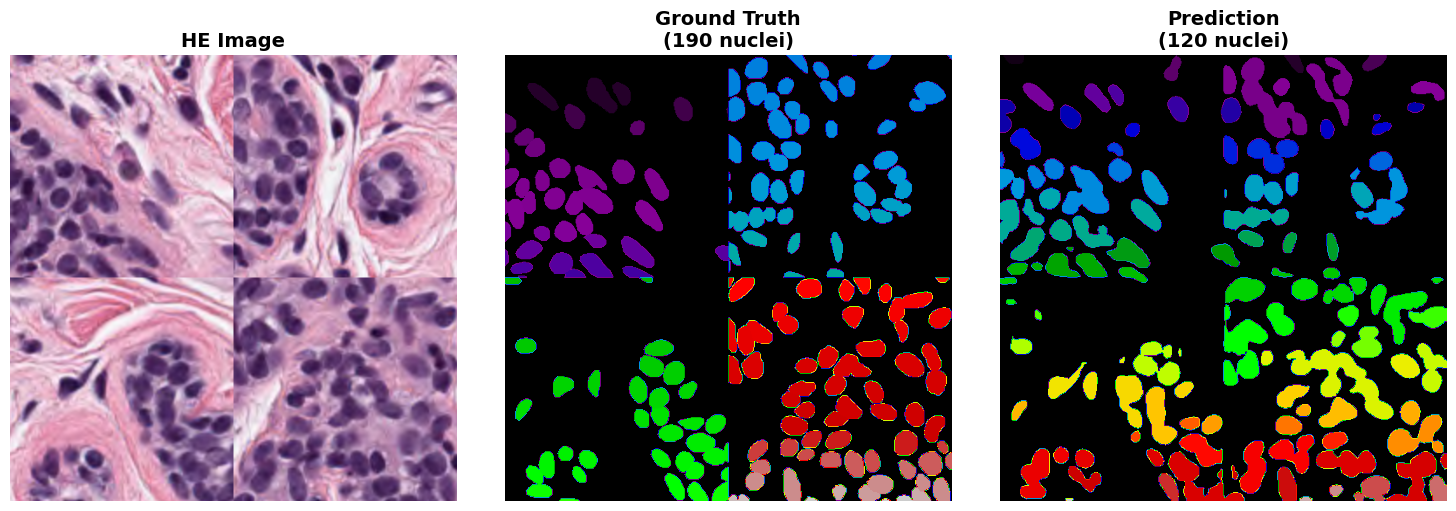

In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
from skimage.morphology import remove_small_objects
import random

# ==================== CONFIG ====================
MODEL_PATH = "improved_step4_aug_val_best_ema.pth"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CHUNK_SIZE = 65536
MAGNIFICATION = 40  # Set to 20 or 40

# ==================== UTILITIES ====================
def remap_label(pred):
    """Remap instance labels to be sequential starting from 1"""
    pred_id = list(np.unique(pred))
    if 0 in pred_id:
        pred_id.remove(0)
    if len(pred_id) == 0:
        return pred
    pred_inst_type = np.zeros_like(pred)
    for idx, inst_id in enumerate(pred_id):
        pred_inst_type[pred == inst_id] = idx + 1
    return pred_inst_type

def binarize(pred_inst_type):
    """Convert multi-class instance map to binary instance map"""
    pred_inst = np.zeros_like(pred_inst_type[:, :, 0])
    for i in range(pred_inst_type.shape[-1]):
        pred_inst[pred_inst_type[:, :, i] > 0] = i + 1
    return pred_inst

def embeddings_to_instances(binary_mask, min_size=15):
    mask = binary_mask > 0.5
    labels = label(mask, connectivity=2)
    labels = remove_small_objects(labels, min_size=min_size)
    return labels

def get_fast_pq(true, pred, match_iou=0.5):
    """
    Fast Panoptic Quality calculation (CellViT style)
    Returns: [dq, sq, pq], per_class_metrics
    """
    true = remap_label(true)
    pred = remap_label(pred)
    
    pred_ids = np.unique(pred)[1:]  # Remove background
    gt_ids = np.unique(true)[1:]
    
    if len(pred_ids) == 0 and len(gt_ids) == 0:
        return [1.0, 1.0, 1.0], {}
    if len(pred_ids) == 0 or len(gt_ids) == 0:
        return [0.0, 0.0, 0.0], {}
    
    # IoU matrix
    iou_matrix = np.zeros((len(gt_ids), len(pred_ids)))
    for i, gt_id in enumerate(gt_ids):
        gt_mask = (true == gt_id)
        for j, pred_id in enumerate(pred_ids):
            pred_mask = (pred == pred_id)
            inter = (gt_mask & pred_mask).sum()
            union = gt_mask.sum() + pred_mask.sum() - inter
            if union > 0:
                iou_matrix[i, j] = inter / union
    
    # Greedy matching
    matched_gt, matched_pred, iou_sum = set(), set(), 0.0
    iou_copy = iou_matrix.copy()
    
    while iou_copy.max() >= match_iou:
        i, j = np.unravel_index(iou_copy.argmax(), iou_copy.shape)
        matched_gt.add(i)
        matched_pred.add(j)
        iou_sum += iou_copy[i, j]
        iou_copy[i, :] = 0
        iou_copy[:, j] = 0
    
    tp = len(matched_gt)
    fp = len(pred_ids) - len(matched_pred)
    fn = len(gt_ids) - len(matched_gt)
    
    # Metrics (Graham et al. 2019 formula)
    dq = tp / (tp + 0.5*fp + 0.5*fn) if (tp + fp + fn) > 0 else 0
    sq = iou_sum / tp if tp > 0 else 0
    pq = dq * sq
    
    return [dq, sq, pq], {}

# ==================== LOAD & INFERENCE ====================
print("📂 Loading model...")
ema.module.load_state_dict(torch.load(MODEL_PATH))
ema.module.eval()

# Get RANDOM sample
random_idx = random.randint(0, len(test_loader.dataset) - 1)
print(f"🎲 Selected random sample: {random_idx} / {len(test_loader.dataset)}")

sample = test_loader.dataset[random_idx]
he_image = sample['he_image'].unsqueeze(0).to(DEVICE)
gt_inst = sample['he_nuclei_instance'].numpy()

B, C, H, W = he_image.shape
print(f"📐 Image shape: {H}x{W}")

# Create coordinates
y = torch.linspace(0, 1, H, device=DEVICE)
x = torch.linspace(0, 1, W, device=DEVICE)
gy, gx = torch.meshgrid(y, x, indexing='ij')
coords = torch.stack([gx.flatten(), gy.flatten()], dim=1)

# Inference
print("🚀 Running inference...")
binary_chunks = []
with torch.no_grad():
    for k in range(0, len(coords), CHUNK_SIZE):
        chunk = coords[k:k+CHUNK_SIZE].unsqueeze(0)
        b_pred, _ = ema.module(he_image, chunk, return_logits=False)
        binary_chunks.append(b_pred.cpu())

binary_pred = torch.cat(binary_chunks, 1).view(H, W).numpy()
inst_pred = embeddings_to_instances(binary_pred)

# ==================== CALCULATE PQ (CellViT Style) ====================
# Remap labels before PQ calculation
remapped_gt = remap_label(gt_inst)
remapped_pred = remap_label(inst_pred)

[dq, sq, pq], _ = get_fast_pq(true=remapped_gt, pred=remapped_pred, match_iou=0.5)

# ==================== VISUALIZE ====================
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original image
axes[0].imshow(he_image[0].cpu().permute(1, 2, 0).numpy())
axes[0].set_title("HE Image", fontsize=14, fontweight='bold')
axes[0].axis('off')

# Ground truth
axes[1].imshow(gt_inst, cmap='nipy_spectral')
axes[1].set_title(f"Ground Truth\n({len(np.unique(gt_inst))-1} nuclei)", 
                  fontsize=14, fontweight='bold')
axes[1].axis('off')

# Prediction
axes[2].imshow(inst_pred, cmap='nipy_spectral')
axes[2].set_title(f"Prediction\n({len(np.unique(inst_pred))-1} nuclei)", 
                  fontsize=14, fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.savefig(f"nuclei_result_sample_{random_idx}.png", dpi=150, bbox_inches='tight')
print(f"✅ Saved: nuclei_result_sample_{random_idx}.png")

# ==================== METRICS ====================
print(f"\n{'='*60}")
print(f"📊 PANOPTIC QUALITY (CellViT-style)")
print(f"{'='*60}")
print(f"PQ (Panoptic Quality):      {pq:.4f}  [DQ × SQ]")
print(f"SQ (Segmentation Quality):  {sq:.4f}  [Σ IoU / |TP|]")
print(f"DQ (Detection Quality):     {dq:.4f}  [|TP| / (|TP| + 0.5|FP| + 0.5|FN|)]")
print(f"{'='*60}")
print(f"GT nuclei:     {len(np.unique(gt_inst))-1}")
print(f"Predicted:     {len(np.unique(inst_pred))-1}")
print(f"Difference:    {len(np.unique(inst_pred))-1 - (len(np.unique(gt_inst))-1):+d}")
print(f"{'='*60}")

plt.show()